In [1]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


/software/cellgen/team361/aa34/envs/disect/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from celldisect import CellDISECT
import rapids_singlecell as rsc
# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [3]:
adata = sc.read_h5ad('../haber_hvg_split.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()

In [4]:
adata.layers['counts'].max()

4385.0

In [5]:
adata.X.max()

8.89436

In [6]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [7]:
cats = ['batch', 'condition', 'cell_label',]
cell_type_included = True # Set to True if you have provided a cell type annotation in the cats list
if not cell_type_included:
    adata.obs["_cluster"] = (
        "0"  # Dummy obs for inference (not-training) time, to avoid computing neighbors and clusters again in setup_anndata | AVOID ADDING BEFORE TRAINING
    )
pre_path = '../models/haber_ablation_celldisect_cfW_all1/'
model_paths = []
for model_path in os.listdir(pre_path):
    model_paths.append(model_path)

In [8]:
model_paths

['celldisect_allones_cfW_6.0_split_split_allOut_TA_salmonella',
 'celldisect_allones_cfW_0.5_split_split_allOut_Enterocyte_hpoly10',
 'celldisect_allones_cfW_1.5_split_split_allOut_Goblet_salmonella',
 'celldisect_allones_cfW_0.05_split_split_allOut_Stem_hpoly10',
 'celldisect_allones_cfW_1.2_split_split_allOut_Goblet_salmonella',
 'celldisect_allones_cfW_3.0_split_split_allOut_Enterocyte_hpoly10',
 'celldisect_allones_cfW_1.0_split_split_allOut_Tuft_salmonella',
 'celldisect_allones_cfW_1.5_split_split_allOut_Tuft_salmonella',
 'celldisect_allones_cfW_1.0_split_split_allOut_Tuft_hpoly10',
 'celldisect_allones_cfW_0.8_split_split_allOut_Enterocyte_salmonella',
 'celldisect_allones_cfW_2.5_split_split_allOut_Enterocyte.Progenitor_hpoly10',
 'celldisect_allones_cfW_0.7_split_split_allOut_Enterocyte.Progenitor_hpoly10',
 'celldisect_allones_cfW_0.0_split_split_allOut_Goblet_hpoly10',
 'celldisect_allones_cfW_0.05_split_split_allOut_Enterocyte.Progenitor_hpoly10',
 'celldisect_allones_cfW_

In [9]:
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import gc

ood_cts = adata.obs['cell_label'].unique()
scenario = 'allOut'

cov_names = ['condition']
cov_values = ['Control']
n_samples_from_source_max = 500

emd_results_all = []
r2_results_all = []
r2_results_subtract_all = []

for cond in ['salmonella', 'hpoly10']:
    if cond == 'salmonella':
        cov_values_cf = ['Salmonella']
    else:
        cov_values_cf = ['Hpoly.Day10']
    for cell_type_to_check in tqdm(ood_cts):
        filtered_model_paths = [path for path in model_paths if (cond in path and cell_type_to_check in path)]
        names = [name.split('_')[3] for name in filtered_model_paths]
        
        models = {}
        for i, model_path in enumerate(filtered_model_paths):
            models[names[i]] = CellDISECT.load(f"{pre_path}/{model_path}", adata=adata)
            
        models = dict(sorted(models.items(), key=lambda t: float(t[0])))
        
        gc.collect()
        n_samples_from_source = min(n_samples_from_source_max,
                                    len(adata[(adata.obs['cell_label'] == cell_type_to_check)
                                            & (adata.obs['condition'] == 'Control')]))
        
        RANDOM_SEED = 42
        preds = {}
        for name, model in models.items():
            x_ctrl, x_true, x_pred = model.predict_counterfactuals(
                                                adata[(adata.obs['cell_label'] == cell_type_to_check)].copy(),
                                                cov_names=cov_names,
                                                cov_values=cov_values,
                                                cov_values_cf=cov_values_cf,
                                                cats=cats,
                                                n_samples_from_source=n_samples_from_source,
                                                seed=RANDOM_SEED,
                                                )
            x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)
            preds[name] = x_pred
        
        deg_list = adata.uns['rank_genes_groups'][f'{cell_type_to_check}_{cov_values_cf[0]}']


        emd_results = {}
        for n_top_deg in [20, None]:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
            emd_results[str(n_top_deg)] = {}
            for name, x_pred in preds.items():
                x_true_deg = x_true[:, degs]
                x_pred_deg = x_pred[:, degs]
                # for method_name, method in zip(['CellDISECT', 'Control'], [x_pred_deg, x_ctrl_deg]):
                wd = []
                for i in range(x_true_deg.shape[1]):
                    wd.append(
                        wasserstein_distance(torch.tensor(x_true_deg[:, i]), torch.tensor(x_pred_deg[:, i]))
                    )
                emd_results[str(n_top_deg)][name] = np.mean(wd)

        emd_results = pd.DataFrame.from_dict(emd_results).T
        
        r2_results = {}
        for n_top_deg in [20, None]:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
            r2_results[str(n_top_deg)] = {}
            for name, x_pred in preds.items():

                x_true_deg = x_true[:, degs]
                x_pred_deg = x_pred[:, degs]

                r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))

                r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))

                r2_results[str(n_top_deg)][name] = r2_mean_deg[0]

                r2_results[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

        r2_results = pd.DataFrame.from_dict(r2_results).T
        
        r2_results_subtract = {}
        for n_top_deg in [20, None]:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
            r2_results_subtract[str(n_top_deg)] = {}
            for name, x_pred in preds.items():

                x_true_deg = x_true[:, degs]
                x_pred_deg = x_pred[:, degs]
                x_ctrl_deg = x_ctrl[:, degs]


                r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))

                r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

                r2_results_subtract[str(n_top_deg)][name] = r2_mean_deg[0]

                r2_results_subtract[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

        r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T
        
        emd_results_all.append(emd_results)
        r2_results_all.append(r2_results)
        r2_results_subtract_all.append(r2_results_subtract)

  0%|          | 0/8 [00:00<?, ?it/s]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.1_split_split_allOut_Enterocyte.Pro
         genitor_salmonella/model.pt already downloaded                                                            


CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.0_split_split_allOut_Enterocyte.Pro
         genitor_salmonella/model.pt already downloaded                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_10.0_split_split_allOut_Enterocyte.Pr
         ogenitor_salmonella/model.pt already downloaded                                                           
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.2_split_split_allOut_Enterocyte.Pro
         genitor_salmonella/model.pt already downloaded                 

 12%|█▎        | 1/8 [00:39<04:36, 39.54s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_2.5_split_split_allOut_Stem_salmonell
         a/model.pt already downloaded                                                                             
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.2_split_split_allOut_Stem_salmonell
         a/model.pt already downloaded                                                                             
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.5_split_split_allOut_Stem_salmonell
         a/model.pt already downloaded                                  

 25%|██▌       | 2/8 [01:16<03:49, 38.30s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.05_split_split_allOut_TA.Early_salm
         onella/model.pt already downloaded                                                                        
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.0_split_split_allOut_TA.Early_salmo
         nella/model.pt already downloaded                                                                         
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.0_split_split_allOut_TA.Early_salmo
         nella/model.pt already downloaded                              

 38%|███▊      | 3/8 [01:55<03:12, 38.45s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_6.0_split_split_allOut_TA_salmonella/
         model.pt already downloaded                                                                               
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_10.0_split_split_allOut_TA_salmonella
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.2_split_split_allOut_TA_salmonella/
         model.pt already downloaded                                    

 50%|█████     | 4/8 [02:33<02:33, 38.42s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.0_split_split_allOut_Tuft_salmonell
         a/model.pt already downloaded                                                                             
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Tuft_salmonell
         a/model.pt already downloaded                                                                             
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_6.0_split_split_allOut_Tuft_salmonell
         a/model.pt already downloaded                                  

 62%|██████▎   | 5/8 [02:55<01:37, 32.49s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.8_split_split_allOut_Enterocyte_sal
         monella/model.pt already downloaded                                                                       
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.1_split_split_allOut_Enterocyte.Pro
         genitor_salmonella/model.pt already downloaded                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Enterocyte_sal
         monella/model.pt already downloaded                            

 75%|███████▌  | 6/8 [03:41<01:13, 36.77s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Goblet_salmone
         lla/model.pt already downloaded                                                                           
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.2_split_split_allOut_Goblet_salmone
         lla/model.pt already downloaded                                                                           
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_7.5_split_split_allOut_Goblet_salmone
         lla/model.pt already downloaded                                

 88%|████████▊ | 7/8 [04:08<00:33, 33.86s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_8.5_split_split_allOut_Endocrine_salm
         onella/model.pt already downloaded                                                                        
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.0_split_split_allOut_Endocrine_salm
         onella/model.pt already downloaded                                                                        
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.8_split_split_allOut_Endocrine_salm
         onella/model.pt already downloaded                             

  0%|          | 0/8 [00:00<?, ?it/s]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_2.5_split_split_allOut_Enterocyte.Pro
         genitor_hpoly10/model.pt already downloaded                                                               
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.7_split_split_allOut_Enterocyte.Pro
         genitor_hpoly10/model.pt already downloaded                                                               
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.05_split_split_allOut_Enterocyte.Pr
         ogenitor_hpoly10/model.pt already downloaded                   

 12%|█▎        | 1/8 [00:47<05:29, 47.08s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.05_split_split_allOut_Stem_hpoly10/
         model.pt already downloaded                                                                               
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Stem_hpoly10/m
         odel.pt already downloaded                                                                                
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.5_split_split_allOut_Stem_hpoly10/m
         odel.pt already downloaded                                     

 25%|██▌       | 2/8 [01:29<04:25, 44.26s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_7.5_split_split_allOut_TA.Early_hpoly
         10/model.pt already downloaded                                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.0_split_split_allOut_TA.Early_hpoly
         10/model.pt already downloaded                                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_10.0_split_split_allOut_TA.Early_hpol
         y10/model.pt already downloaded                                

 38%|███▊      | 3/8 [02:11<03:36, 43.36s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_10.0_split_split_allOut_TA_hpoly10/mo
         del.pt already downloaded                                                                                 
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_7.5_split_split_allOut_TA.Early_hpoly
         10/model.pt already downloaded                                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_2.0_split_split_allOut_TA_hpoly10/mod
         el.pt already downloaded                                       

 50%|█████     | 4/8 [02:53<02:50, 42.74s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.0_split_split_allOut_Tuft_hpoly10/m
         odel.pt already downloaded                                                                                
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.5_split_split_allOut_Tuft_hpoly10/m
         odel.pt already downloaded                                                                                
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.1_split_split_allOut_Tuft_hpoly10/m
         odel.pt already downloaded                                     

 62%|██████▎   | 5/8 [03:18<01:48, 36.31s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.5_split_split_allOut_Enterocyte_hpo
         ly10/model.pt already downloaded                                                                          
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.0_split_split_allOut_Enterocyte_hpo
         ly10/model.pt already downloaded                                                                          
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_2.5_split_split_allOut_Enterocyte.Pro
         genitor_hpoly10/model.pt already downloaded                    

 75%|███████▌  | 6/8 [04:01<01:17, 38.73s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.0_split_split_allOut_Goblet_hpoly10
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_6.0_split_split_allOut_Goblet_hpoly10
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_8.5_split_split_allOut_Goblet_hpoly10
         /model.pt already downloaded                                   

 88%|████████▊ | 7/8 [04:32<00:36, 36.05s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.7_split_split_allOut_Endocrine_hpol
         y10/model.pt already downloaded                                                                           
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Endocrine_hpol
         y10/model.pt already downloaded                                                                           
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_4.0_split_split_allOut_Endocrine_hpol
         y10/model.pt already downloaded                                

100%|██████████| 8/8 [04:56<00:00, 37.10s/it]


In [10]:
# emd_results_all
# r2_results_all
# r2_results_subtract_all

In [11]:
emd_results = pd.concat([df for df in emd_results_all]).groupby(level=0).mean()
r2_results = pd.concat([df for df in r2_results_all]).groupby(level=0).mean()
r2_results_subtract = pd.concat([df for df in r2_results_subtract_all]).groupby(level=0).mean()

In [12]:
r2_results

0.0   0.0_var      0.01  0.01_var      0.05  0.05_var       0.1  \
20   0.657124  0.651877  0.656711  0.654816  0.651420  0.650594  0.657312   
all  0.192168  0.165348  0.203703  0.171122  0.191581  0.157969  0.198037   

      0.1_var       0.2   0.2_var  ...       5.0   5.0_var       6.0  \
20   0.654878  0.653903  0.650784  ...  0.655716  0.629953  0.639263   
all  0.169493  0.195734  0.163193  ...  0.219072  0.189029  0.233686   

      6.0_var       7.5   7.5_var       8.5   8.5_var      10.0  10.0_var  
20   0.598740  0.628994  0.576007  0.611773  0.541562  0.581811  0.543414  
all  0.222258  0.249562  0.221158  0.252273  0.222602  0.268656  0.214460  

[2 rows x 44 columns]

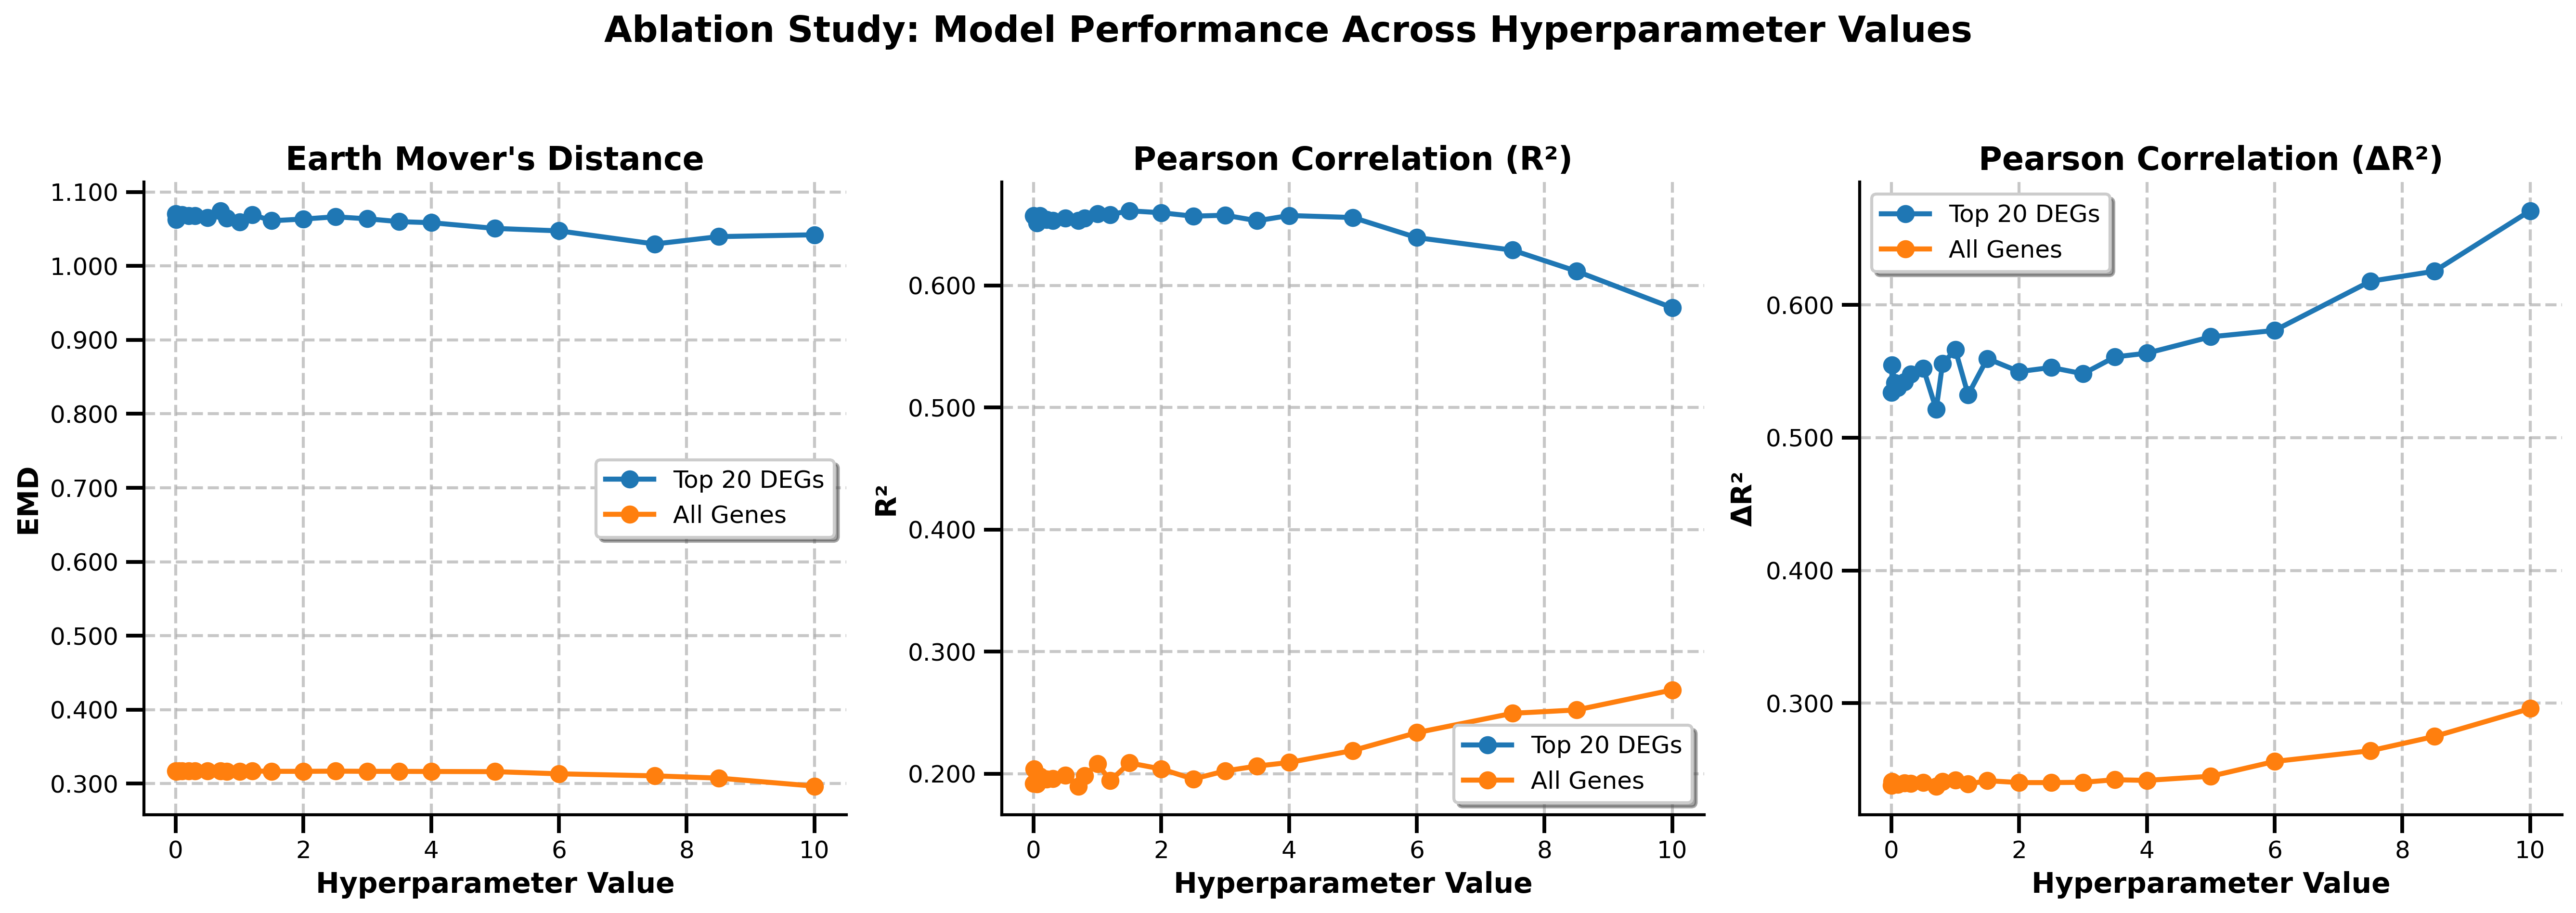

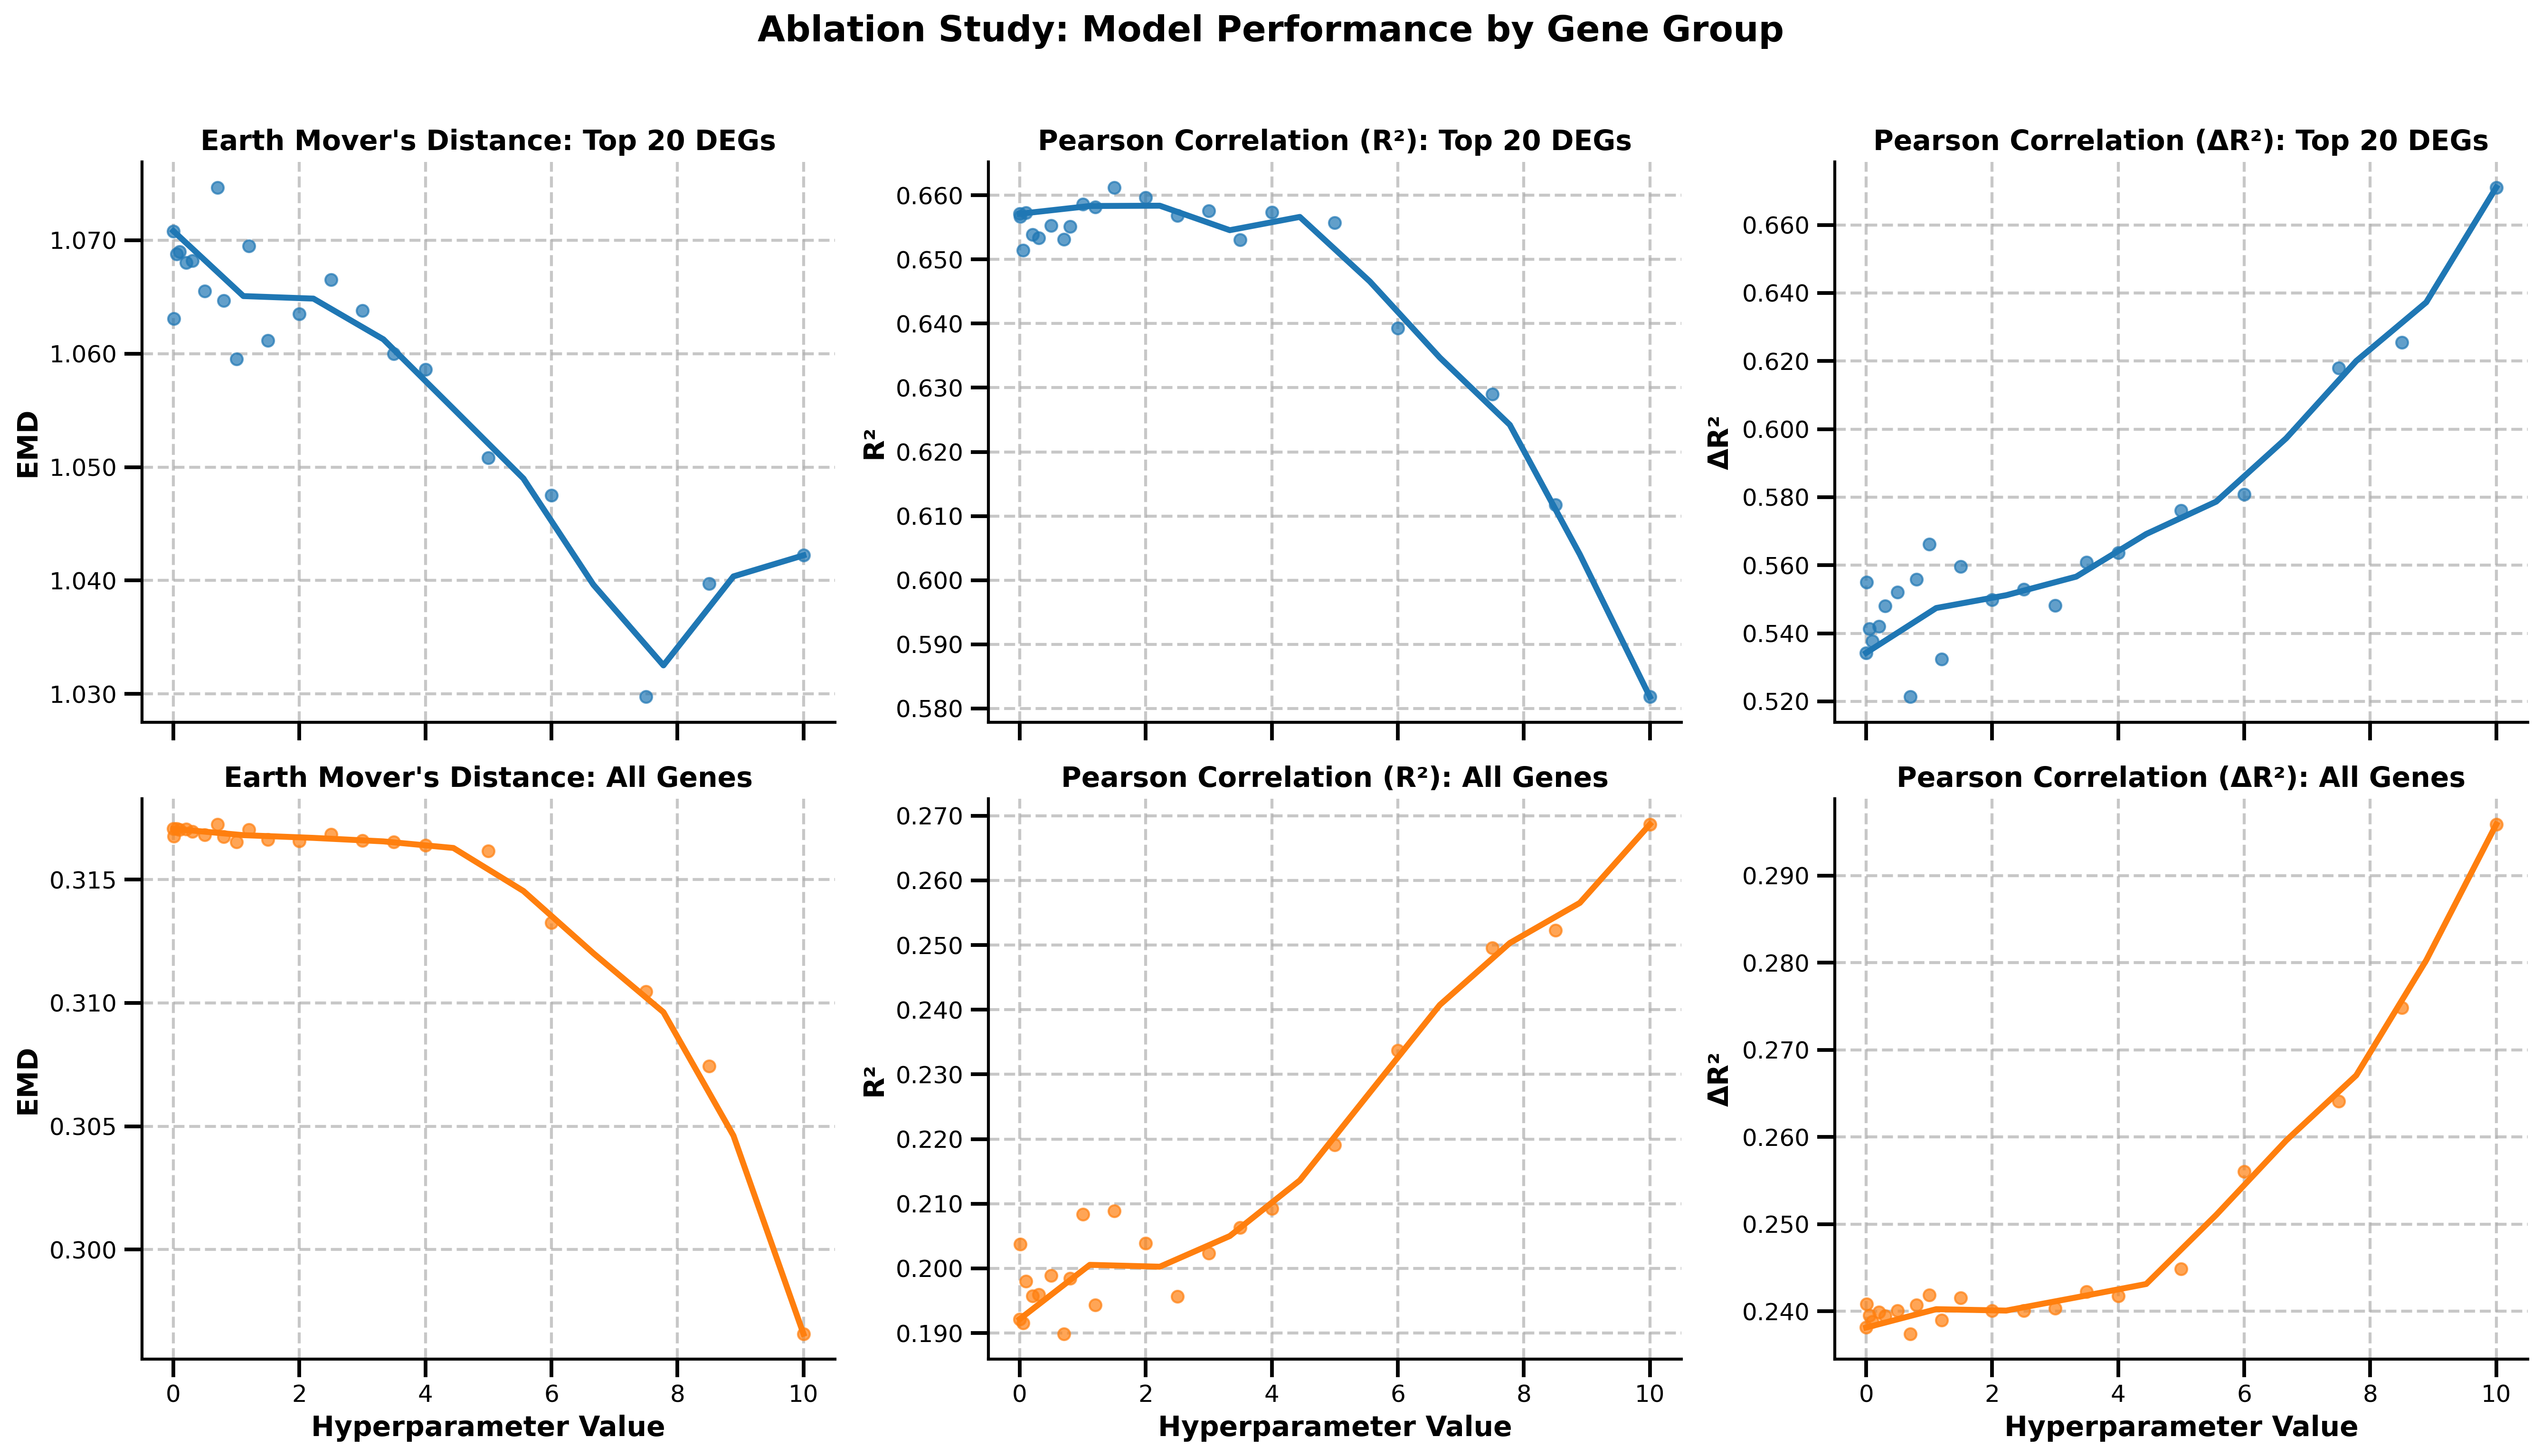

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Function to create smooth curve
def smooth_curve(x, y, smoothness=10):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=1)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a secondary plot with smoothed lines for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes2[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes2[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()

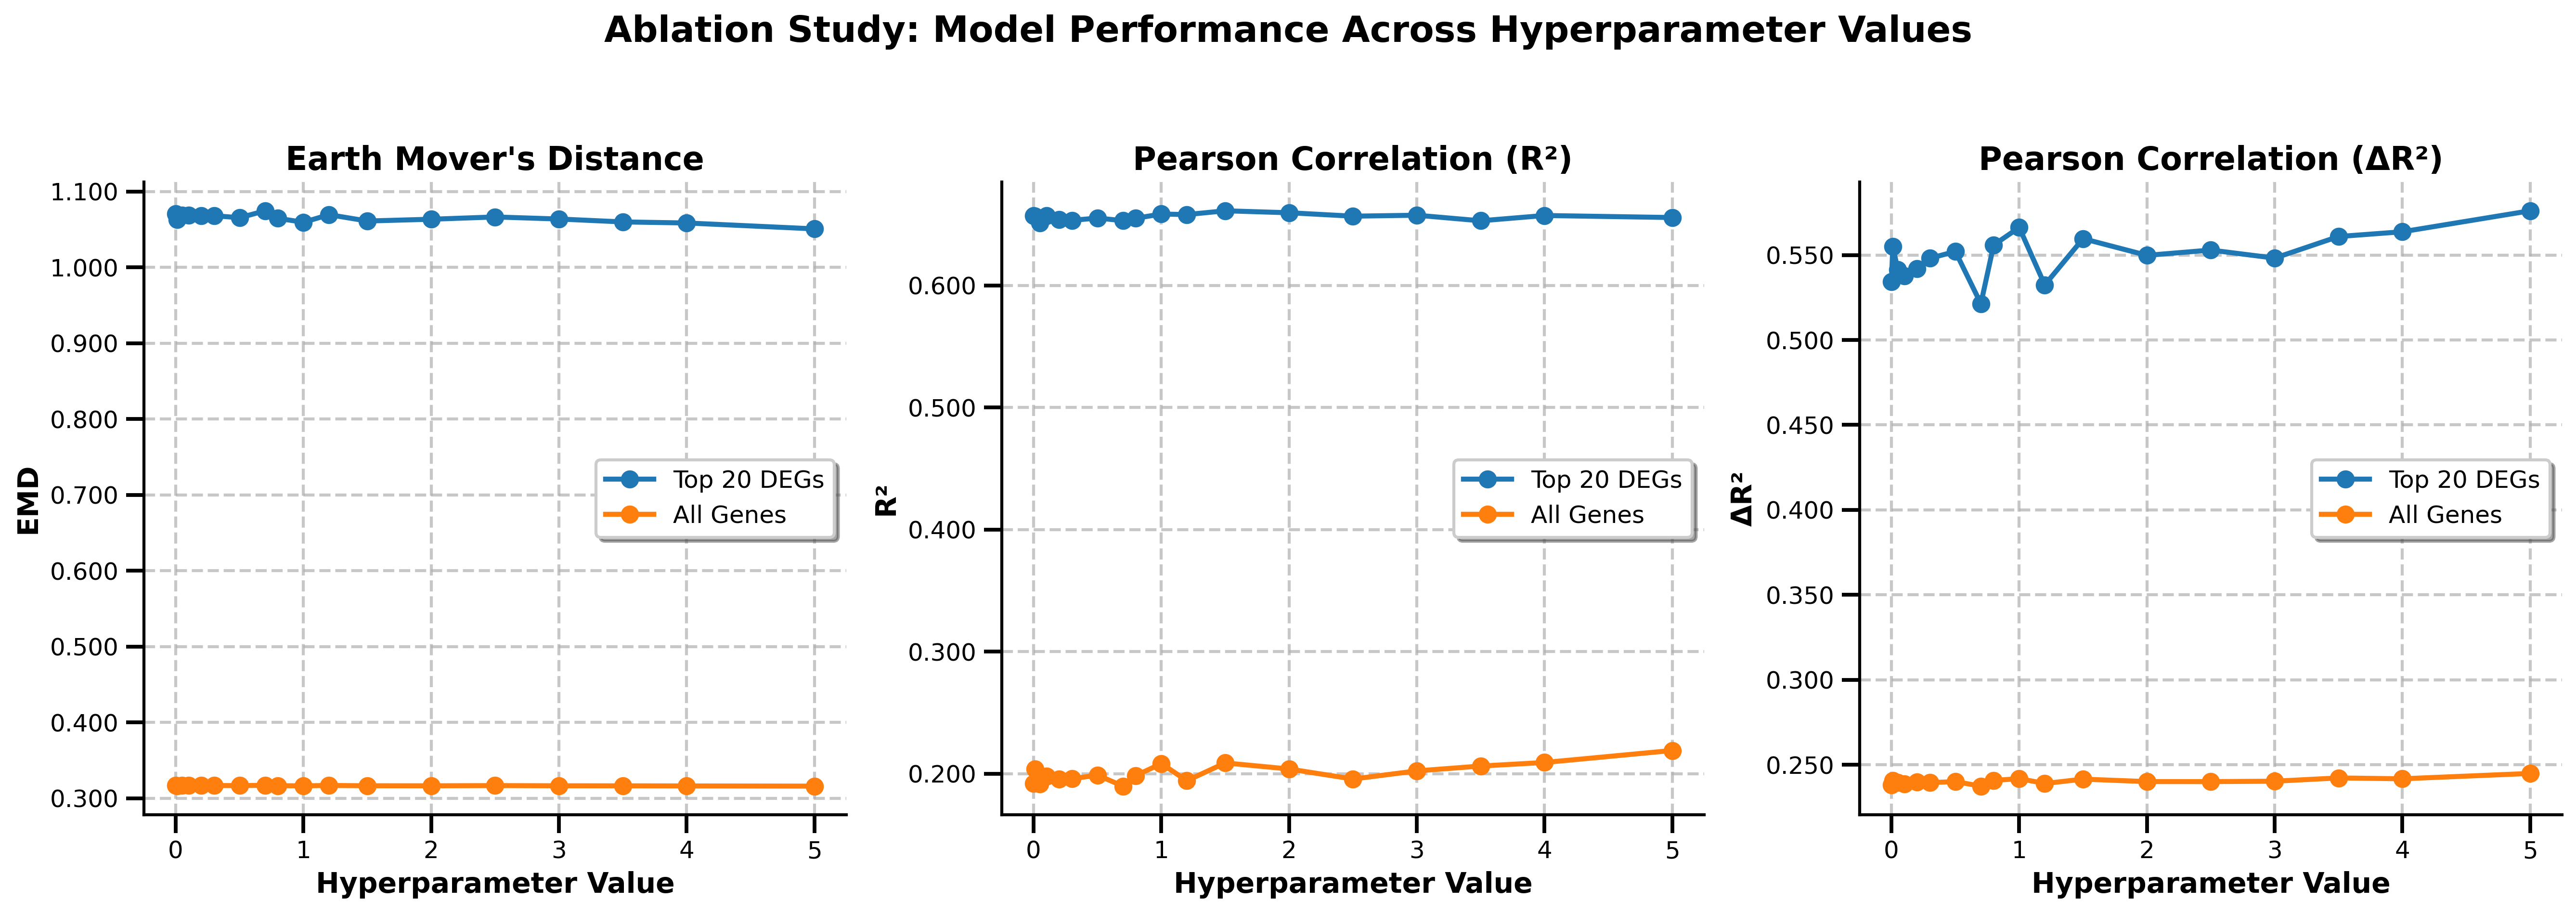

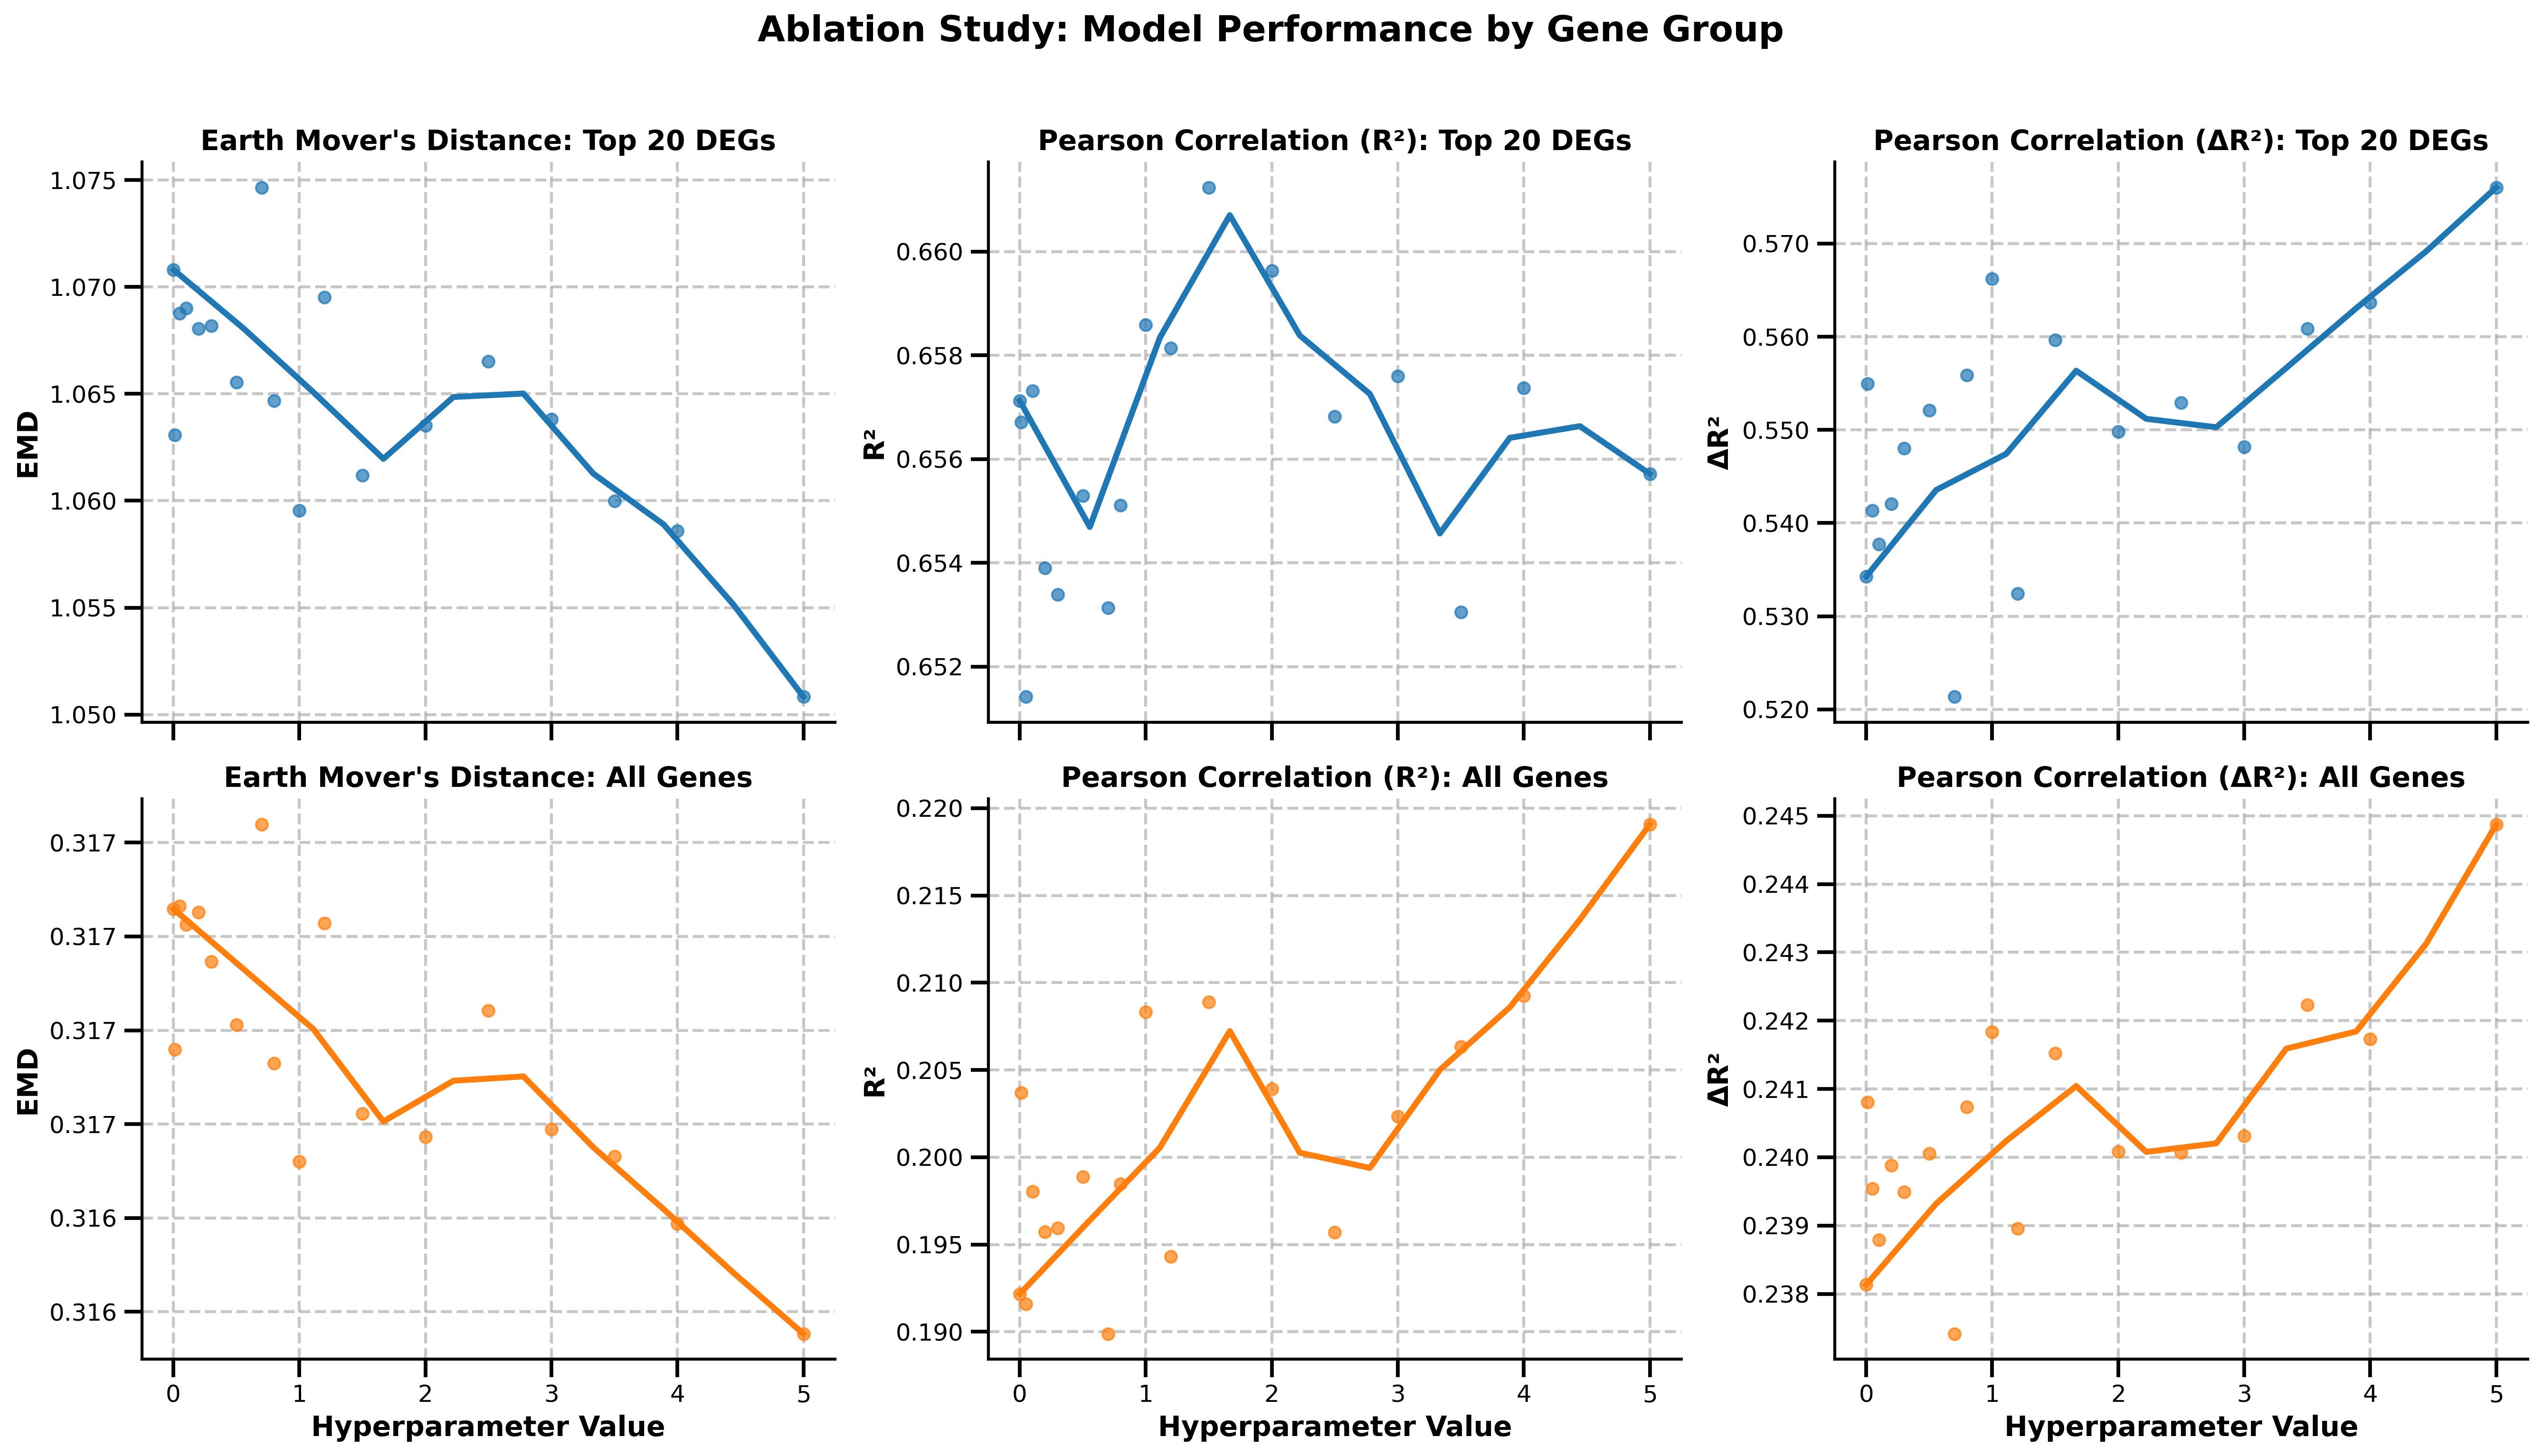

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name, max_weight=None):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    if max_weight is not None:
        hyperparam_values = [col for col in hyperparam_values if float(col) <= max_weight]
        
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name, max_weight=5)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Function to create smooth curve
def smooth_curve(x, y, smoothness=10):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=1)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a secondary plot with smoothed lines for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name, max_weight=5)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes2[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes2[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()

In [15]:
# Kang

In [3]:
adata = sc.read_h5ad('../kang_normalized_hvg.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()

In [4]:
adata.layers['counts'].max()

3828.0

In [5]:
adata.X.max()

9.0423

In [6]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [7]:
cats = ['cell_type', 'condition']
cell_type_included = True # Set to True if you have provided a cell type annotation in the cats list
if not cell_type_included:
    adata.obs["_cluster"] = (
        "0"  # Dummy obs for inference (not-training) time, to avoid computing neighbors and clusters again in setup_anndata | AVOID ADDING BEFORE TRAINING
    )
# pre_path = '../models/kang_ablation_celldisect_cfW_all1_focused/'
pre_path = '../models/kang_ablation_celldisect_cfW_all1_may15/'

model_paths = []
for model_path in os.listdir(pre_path):
    model_paths.append(model_path)

In [8]:
model_paths

['celldisect_allones_cfW_3.0_split_split_CD8 T',
 'celldisect_allones_cfW_0.5_split_split_T',
 'celldisect_allones_cfW_0.7_split_split_CD8 T',
 'celldisect_allones_cfW_3.0_split_split_B',
 'celldisect_allones_cfW_0.01_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.2_split_split_NK',
 'celldisect_allones_cfW_6.0_split_split_B',
 'celldisect_allones_cfW_6.0_split_split_CD8 T',
 'celldisect_allones_cfW_1.5_split_split_CD8 T',
 'celldisect_allones_cfW_2.5_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.7_split_split_DC',
 'celldisect_allones_cfW_0.8_split_split_NK',
 'celldisect_allones_cfW_7.5_split_split_T',
 'celldisect_allones_cfW_0.7_split_split_NK',
 'celldisect_allones_cfW_0.0_split_split_NK',
 'celldisect_allones_cfW_0.5_split_split_NK',
 'celldisect_allones_cfW_0.7_split_split_CD4 T',
 'celldisect_allones_cfW_8.5_split_split_CD16 Mono',
 'celldisect_allones_cfW_3.0_split_split_CD16 Mono',
 'celldisect_allones_cfW_4.0_split_split_CD8 T',
 'celldisect_allones_cfW_0.01_split_s

In [9]:
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
adata.obs['cov_condition'] = adata.obs['cell_type'].astype(str) + '_' + adata.obs.condition.astype(str)

groupby='cov_condition'
control_group='ctrl'
key_added="rank_genes_groups_pval0.05"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
covariate = 'cell_type'
cov_categories = adata.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # name of the control group in the groupby obs column
    control_group_cov = "_".join([cov_cat, control_group])
    adata_cov = adata[adata.obs[covariate] == cov_cat]

    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )

    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns

    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['logfoldchanges']

        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)

        gene_dict[group] = de_genes[group].tolist()

adata.uns[key_added] = gene_dict
adata.X = adata.layers['counts'].copy()

CD14 Mono
CD4 T
T
CD8 T
B
DC
CD16 Mono
NK


In [23]:
emd_results_ = emd_results.copy()
r2_results_ = r2_results.copy()
r2_results_subtract_ = r2_results_subtract.copy()

In [10]:
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import gc

ood_cts = adata.obs['cell_type'].unique()

cov_names = ['condition']
cov_values = ['ctrl']
cov_values_cf = ['stimulated']

n_samples_from_source_max = 500

emd_results_all = []
r2_results_all = []
r2_results_subtract_all = []


for cell_type_to_check in tqdm(ood_cts):
    filtered_model_paths = [path for path in model_paths if cell_type_to_check in path]
    names = [name.split('_')[3] for name in filtered_model_paths]

    models = {}
    for i, model_path in enumerate(filtered_model_paths):
        models[names[i]] = CellDISECT.load(f"{pre_path}/{model_path}", adata=adata)

    models = dict(sorted(models.items(), key=lambda t: float(t[0])))

    gc.collect()
    n_samples_from_source = min(n_samples_from_source_max,
                                len(adata[(adata.obs['cell_type'] == cell_type_to_check)
                                        & (adata.obs['condition'] == 'ctrl')]))

    RANDOM_SEED = 42
    preds = {}
    for name, model in models.items():
        x_ctrl, x_true, x_pred = model.predict_counterfactuals(
                                            adata[(adata.obs['cell_type'] == cell_type_to_check)].copy(),
                                            cov_names=cov_names,
                                            cov_values=cov_values,
                                            cov_values_cf=cov_values_cf,
                                            cats=cats,
                                            n_samples_from_source=n_samples_from_source,
                                            seed=RANDOM_SEED,
                                            )
        x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)
        preds[name] = x_pred

    deg_list = adata.uns[key_added][f'{cell_type_to_check}_stimulated']

    emd_results = {}
    for n_top_deg in [20, None]:
        if n_top_deg is not None:
            degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
        else:
            degs = np.arange(adata.n_vars)
            n_top_deg = 'all'
        emd_results[str(n_top_deg)] = {}
        for name, x_pred in preds.items():
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            # for method_name, method in zip(['CellDISECT', 'Control'], [x_pred_deg, x_ctrl_deg]):
            wd = []
            for i in range(x_true_deg.shape[1]):
                wd.append(
                    wasserstein_distance(torch.tensor(x_true_deg[:, i]), torch.tensor(x_pred_deg[:, i]))
                )
            emd_results[str(n_top_deg)][name] = np.mean(wd)

    emd_results = pd.DataFrame.from_dict(emd_results).T

    r2_results = {}
    for n_top_deg in [20, None]:
        if n_top_deg is not None:
            degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
        else:
            degs = np.arange(adata.n_vars)
            n_top_deg = 'all'
        r2_results[str(n_top_deg)] = {}
        for name, x_pred in preds.items():

            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]

            r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))

            r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))

            r2_results[str(n_top_deg)][name] = r2_mean_deg[0]

            r2_results[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

    r2_results = pd.DataFrame.from_dict(r2_results).T

    r2_results_subtract = {}
    for n_top_deg in [20, None]:
        if n_top_deg is not None:
            degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
        else:
            degs = np.arange(adata.n_vars)
            n_top_deg = 'all'
        r2_results_subtract[str(n_top_deg)] = {}
        for name, x_pred in preds.items():

            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]


            r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))

            r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

            r2_results_subtract[str(n_top_deg)][name] = r2_mean_deg[0]

            r2_results_subtract[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

    r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T

    emd_results_all.append(emd_results)
    r2_results_all.append(r2_results)
    r2_results_subtract_all.append(r2_results_subtract)

  0%|          | 0/8 [00:00<?, ?it/s]

INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.01_split_split_CD14      
         Mono/model.pt already downloaded                                                                          


CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_2.5_split_split_CD14       
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_1.2_split_split_CD14       
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_10.0_split_split_CD14      
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_4.0_split_split_CD14       
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldis

 12%|█▎        | 1/8 [00:44<05:14, 44.87s/it]

INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.7_split_split_CD4        
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_10.0_split_split_CD4       
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.1_split_split_CD4        
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.01_split_split_CD4       
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldis

 25%|██▌       | 2/8 [01:30<04:30, 45.10s/it]

INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_3.0_split_split_CD8        
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.5_split_split_T/model.pt 
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.7_split_split_CD8        
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_6.0_split_split_CD8        
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldis

 38%|███▊      | 3/8 [02:01<03:13, 38.65s/it]

INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_3.0_split_split_CD8        
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.7_split_split_CD8        
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_6.0_split_split_CD8        
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_1.5_split_split_CD8        
         T/model.pt already downloaded                                                                             
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldis

 50%|█████     | 4/8 [02:22<02:06, 31.67s/it]

INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_3.0_split_split_B/model.pt 
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_6.0_split_split_B/model.pt 
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.05_split_split_B/model.pt
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_7.5_split_split_B/model.pt 
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldis

 62%|██████▎   | 5/8 [02:51<01:32, 30.93s/it]

INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.7_split_split_DC/model.pt
         already downloaded                                                                                        
INFO     File                                                                                                      
         ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.05_split_split_DC/model.pt    
         already downloaded                                                                                        
INFO     File                                                                                                      
         ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_10.0_split_split_DC/model.pt    
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldis

 75%|███████▌  | 6/8 [03:12<00:55, 27.65s/it]

INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_8.5_split_split_CD16       
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_3.0_split_split_CD16       
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_7.5_split_split_CD16       
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_6.0_split_split_CD16       
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldis

 88%|████████▊ | 7/8 [03:40<00:27, 27.52s/it]

INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.2_split_split_NK/model.pt
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.8_split_split_NK/model.pt
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.7_split_split_NK/model.pt
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldisect_allones_cfW_0.0_split_split_NK/model.pt
         already downloaded                                                                                        
INFO     File ../models/kang_ablation_celldisect_cfW_all1_may15//celldis

100%|██████████| 8/8 [04:01<00:00, 30.16s/it]


In [11]:
emd_results_kang = pd.concat([df for df in emd_results_all]).groupby(level=0).mean()
r2_results_kang = pd.concat([df for df in r2_results_all]).groupby(level=0).mean()
r2_results_subtract_kang = pd.concat([df for df in r2_results_subtract_all]).groupby(level=0).mean()

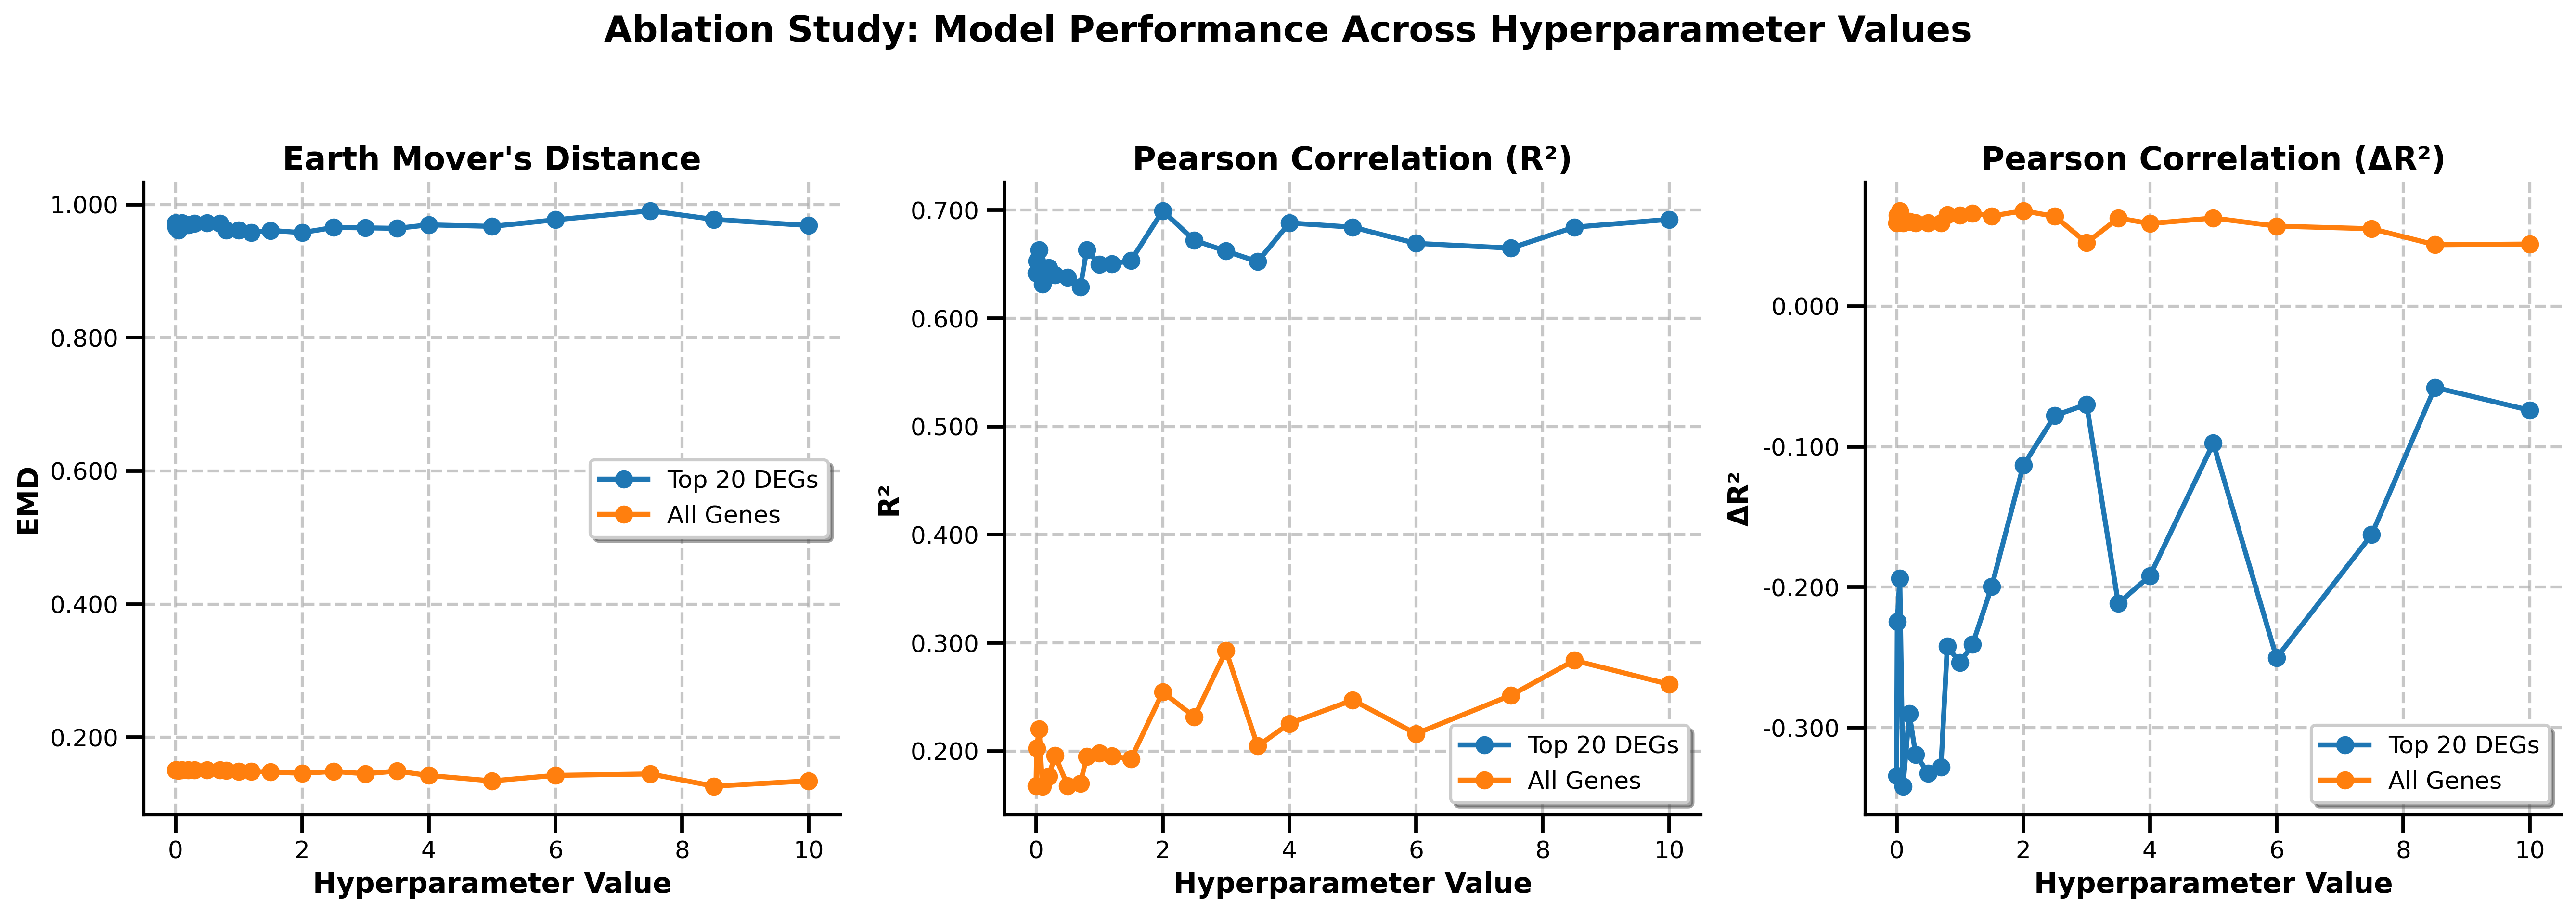

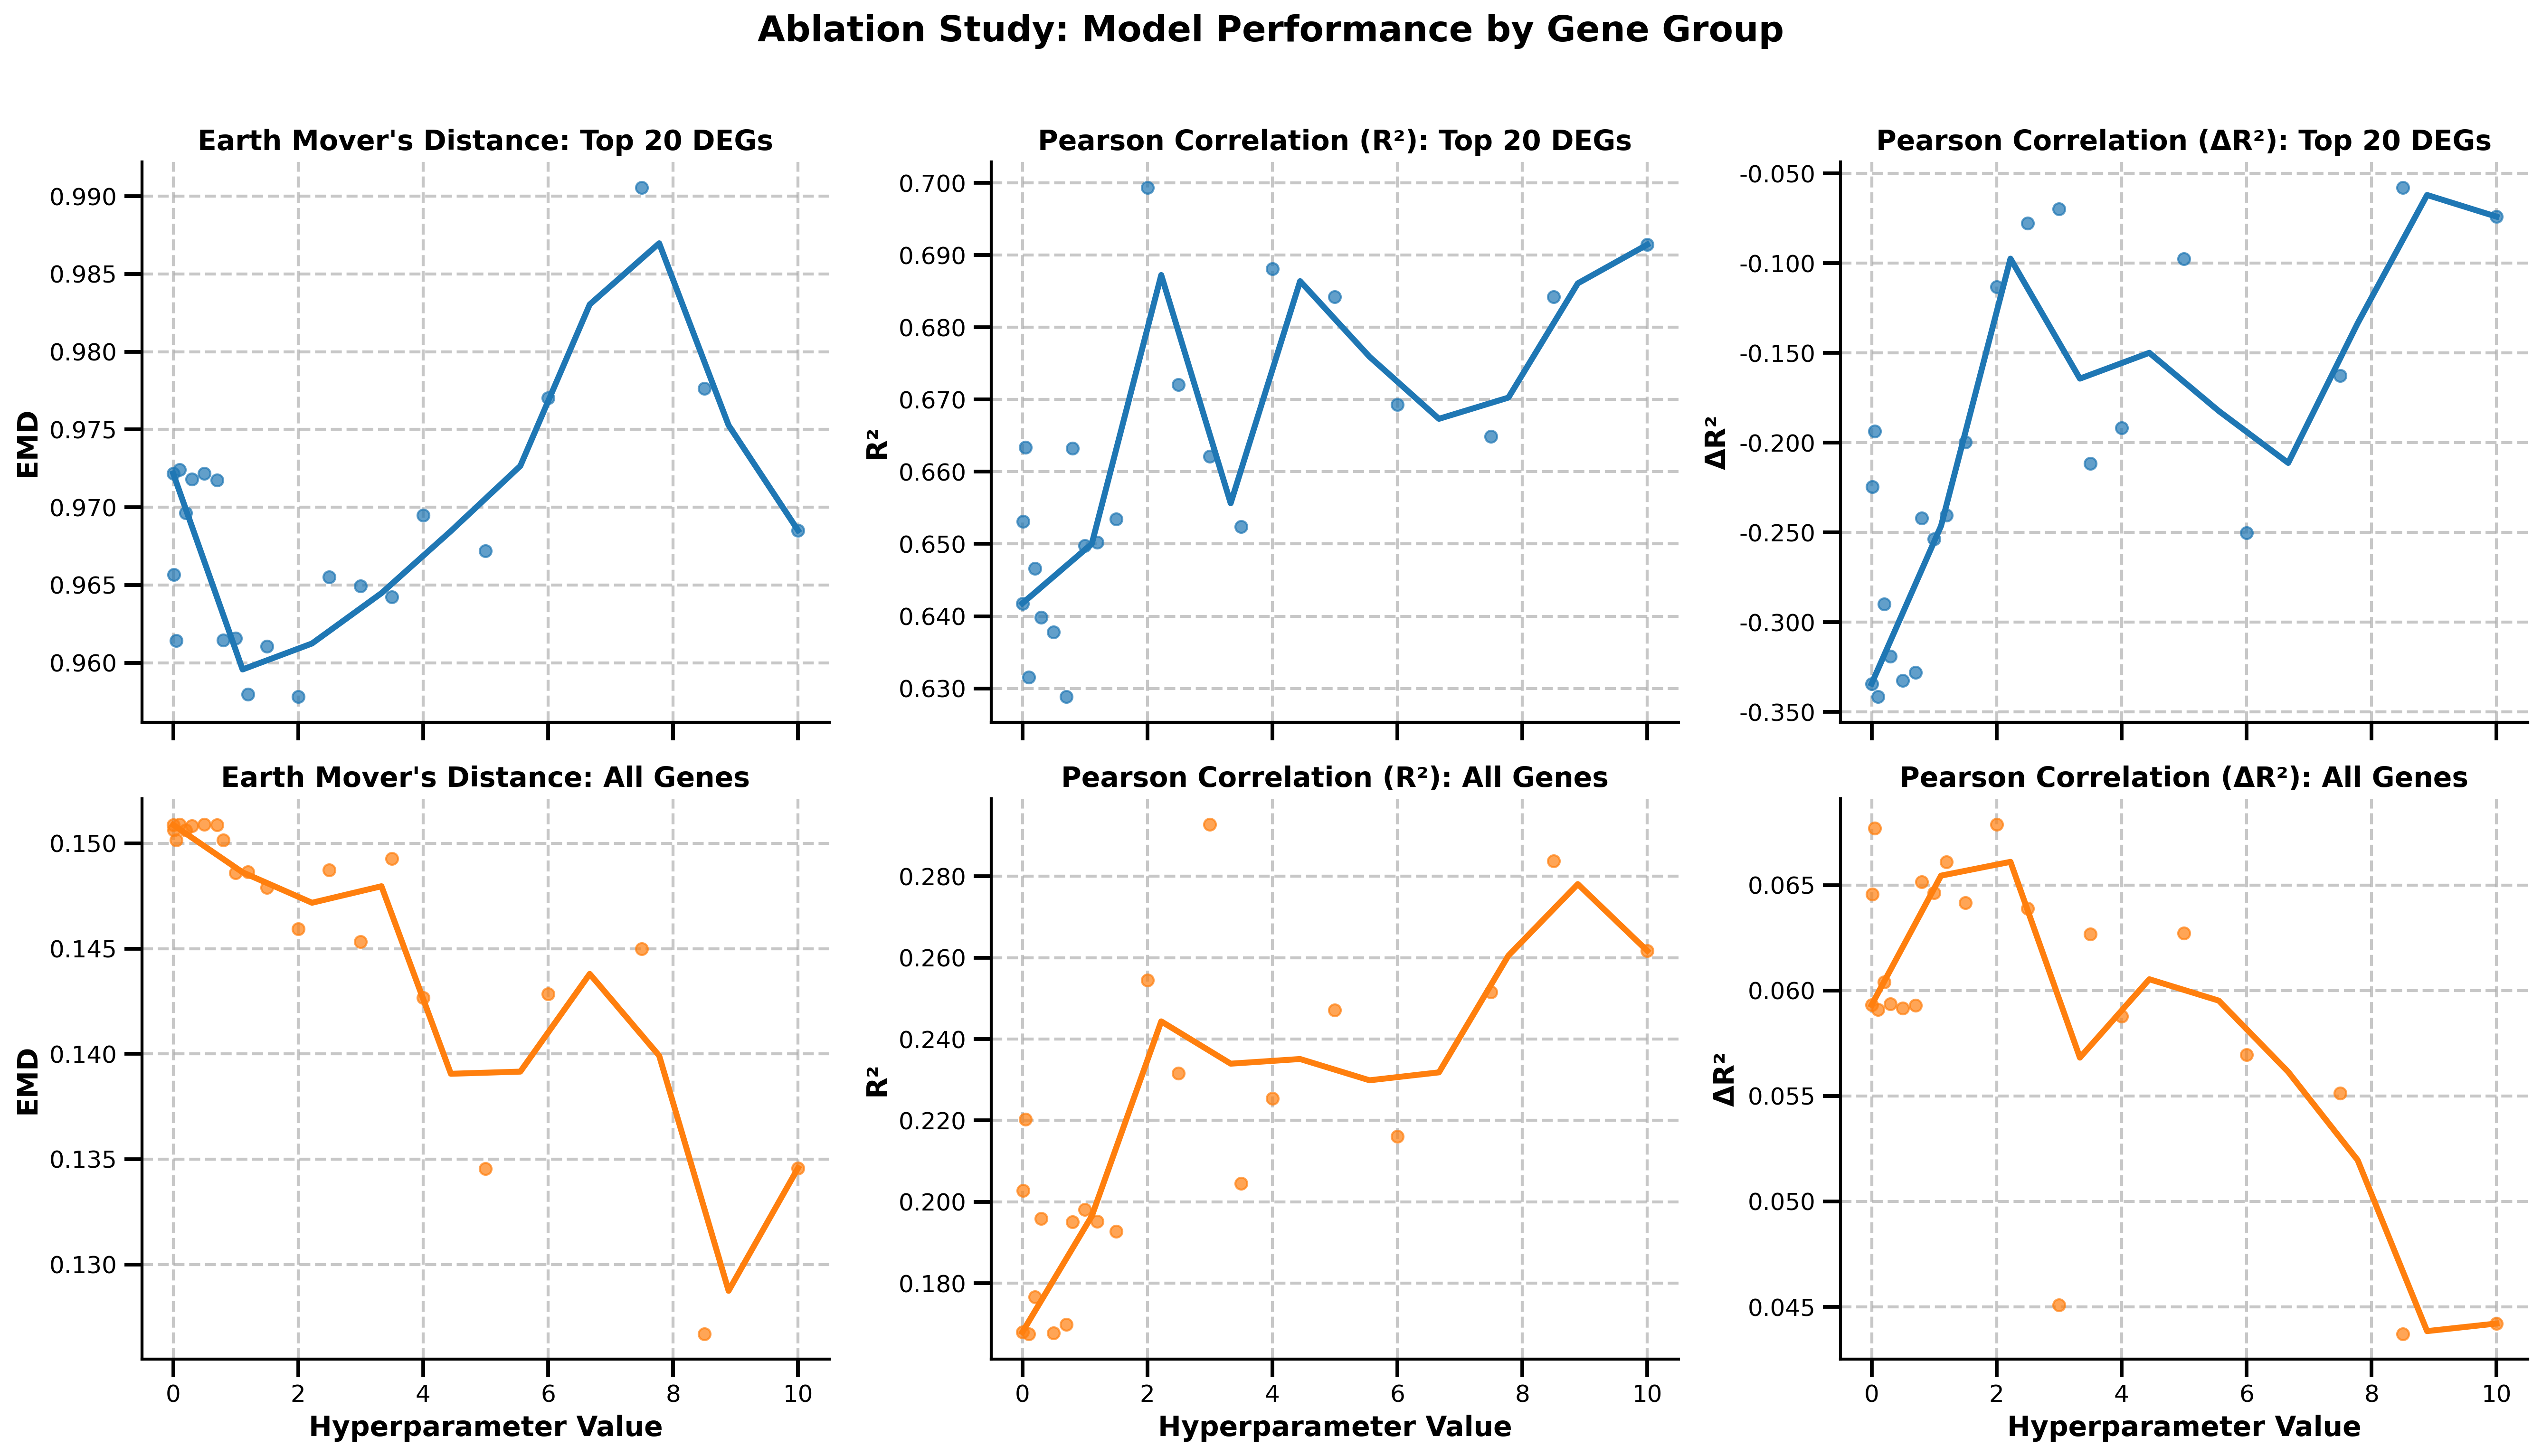

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results_kang,
    'R²': r2_results_kang,
    'ΔR²': r2_results_subtract_kang
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Function to create smooth curve
def smooth_curve(x, y, smoothness=10):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=1)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a secondary plot with smoothed lines for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes2[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes2[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()

In [26]:
emd_results = pd.concat([emd_results_, emd_results_kang], join='inner').groupby(level=0).mean()

r2_results = pd.concat([r2_results_, r2_results_kang], join='inner').groupby(level=0).mean()

r2_results_subtract = pd.concat([r2_results_subtract_, r2_results_subtract_kang], join='inner').groupby(level=0).mean()

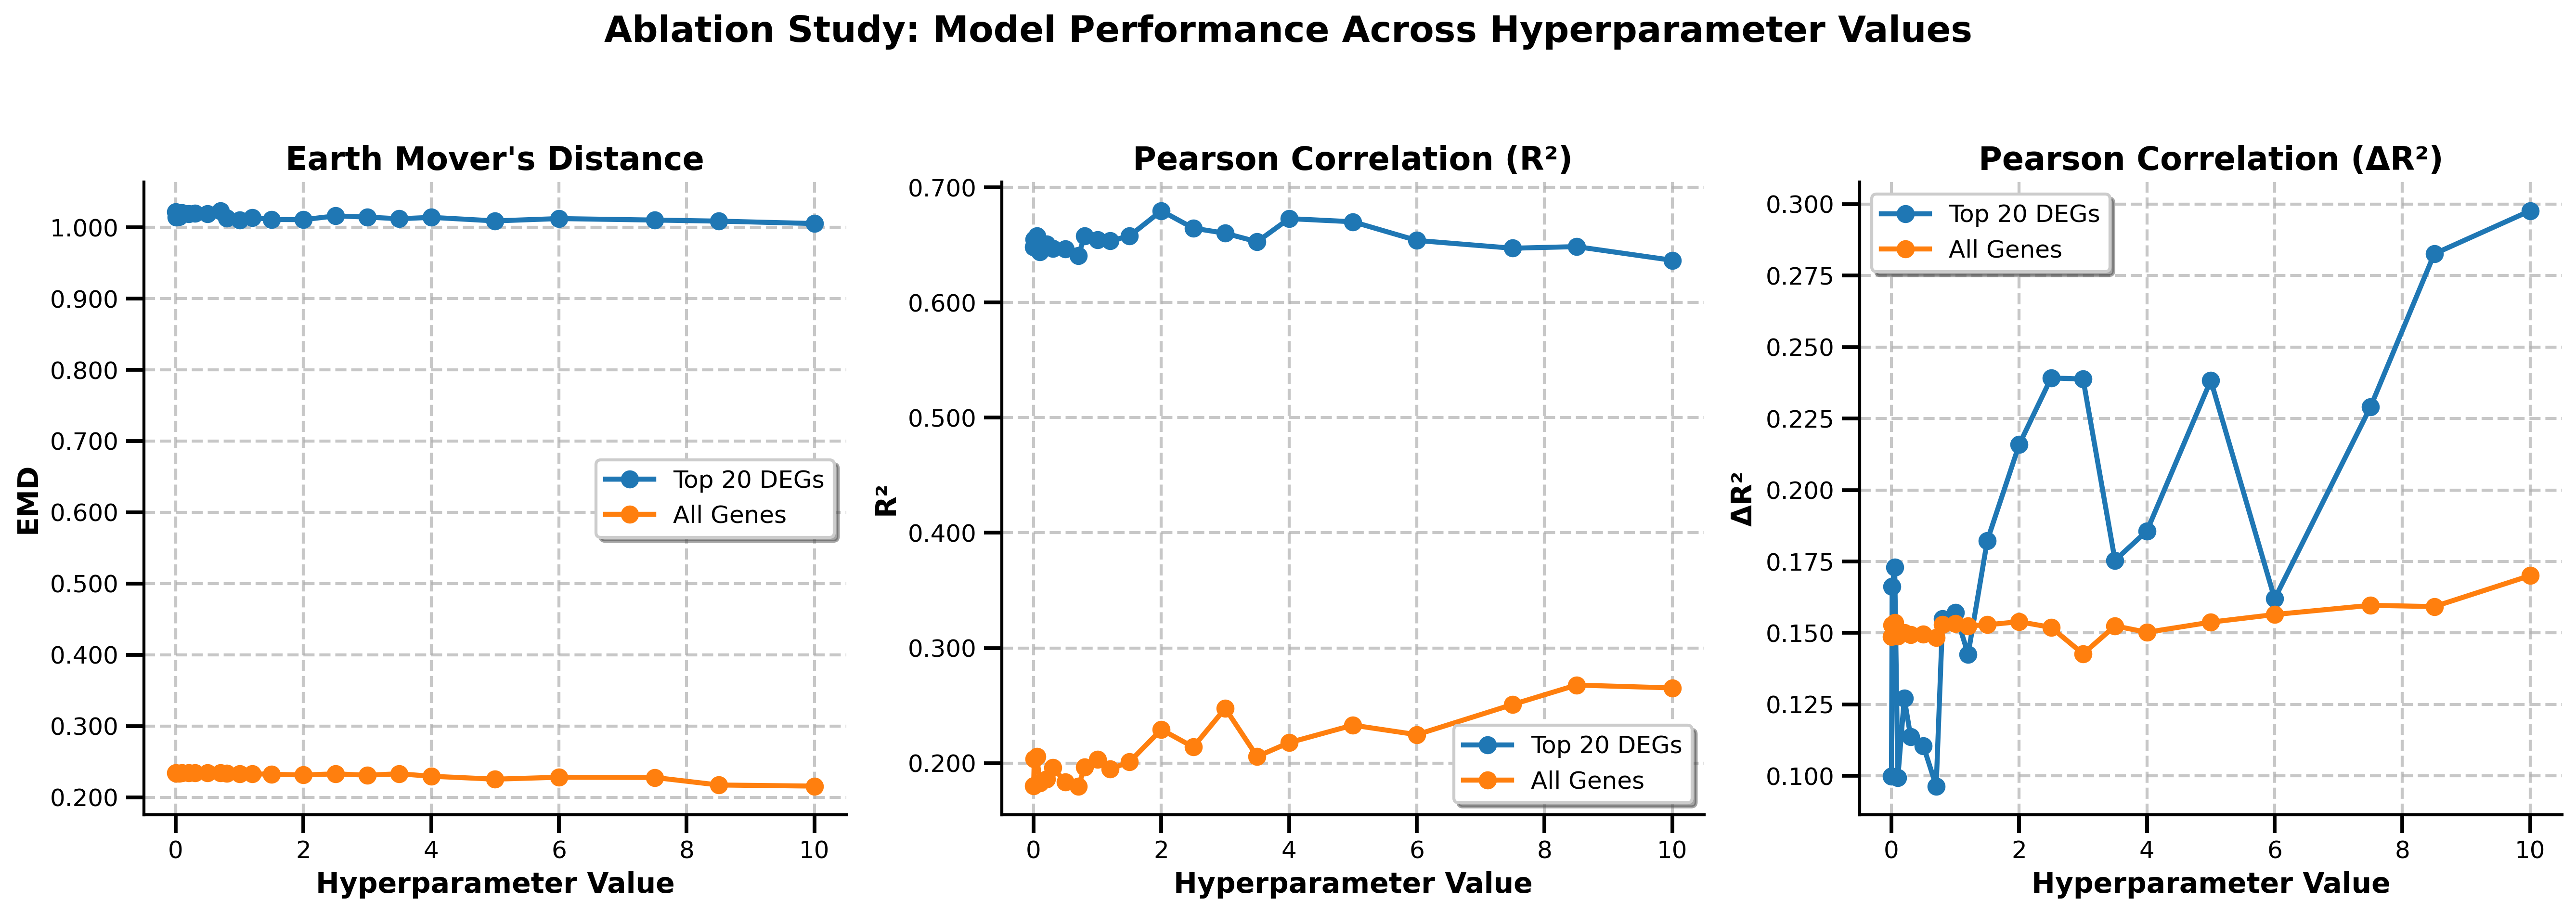

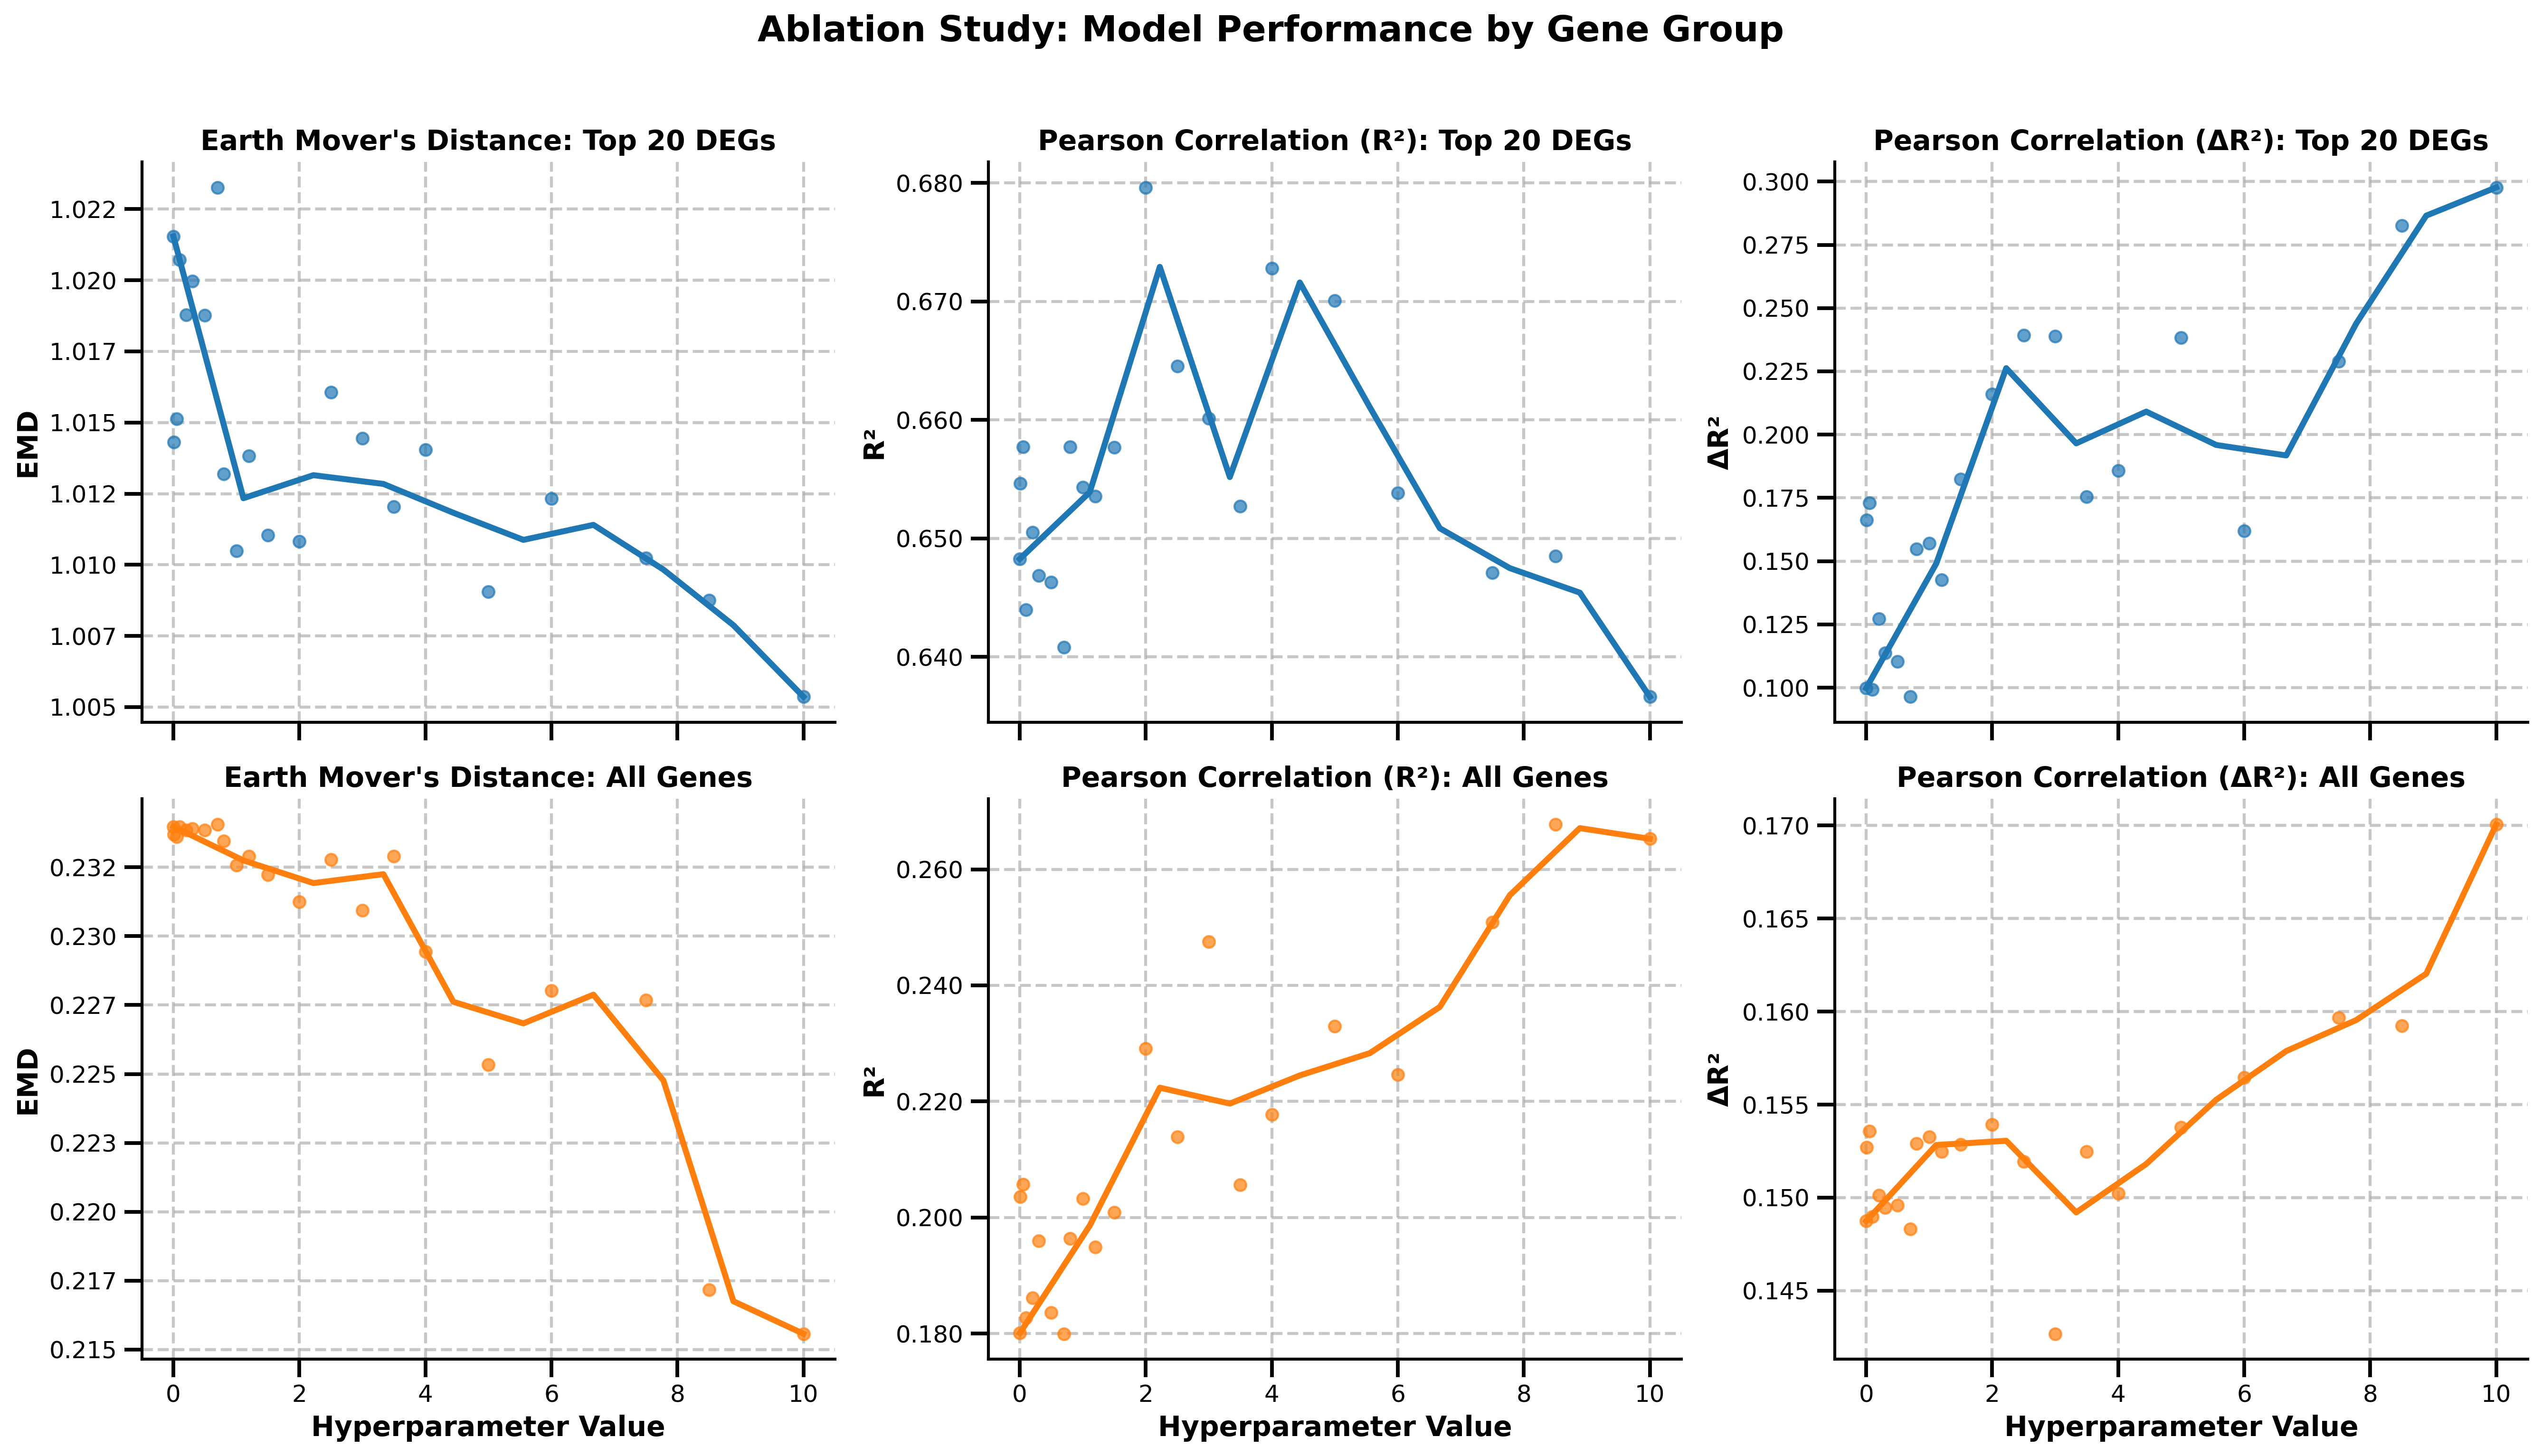

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Function to create smooth curve
def smooth_curve(x, y, smoothness=10):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=1)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a secondary plot with smoothed lines for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes2[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes2[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()

In [28]:
emd_results_mean = pd.DataFrame(emd_results.mean(0)).T
r2_results_mean = pd.DataFrame(r2_results.mean(0)).T
r2_results_subtract_mean = pd.DataFrame(r2_results_subtract.mean(0)).T

In [29]:
emd_results_mean

0.0      0.01      0.05       0.1       0.2       0.3       0.5  \
0  0.62776  0.624004  0.624366  0.627343  0.626321  0.626932  0.626311   

        0.7       0.8       1.0  ...       2.0       2.5       3.0       3.5  \
0  0.628659  0.623322  0.621522  ...  0.621027  0.624425  0.622688  0.622473   

        4.0       5.0       6.0       7.5       8.5      10.0  
0  0.621741  0.617198  0.620181  0.618964  0.612961  0.610468  

[1 rows x 22 columns]

In [30]:
r2_results_mean

0.0   0.0_var      0.01  0.01_var      0.05  0.05_var       0.1  \
0  0.414174  0.310898  0.429117  0.316898  0.431711  0.316534  0.413358   

    0.1_var       0.2   0.2_var  ...       5.0   5.0_var       6.0   6.0_var  \
0  0.310873  0.418348  0.310558  ...  0.451505  0.313436  0.439253  0.302349   

       7.5   7.5_var       8.5   8.5_var      10.0  10.0_var  
0  0.44898  0.306319  0.458119  0.303481  0.450945  0.300316  

[1 rows x 44 columns]

In [31]:
r2_results_subtract_mean

0.0   0.0_var      0.01  0.01_var      0.05  0.05_var       0.1  \
0  0.12428  0.258134  0.159451  0.258836  0.163305  0.258212  0.124169   

    0.1_var       0.2   0.2_var  ...       5.0   5.0_var      6.0   6.0_var  \
0  0.257935  0.138645  0.257921  ...  0.196063  0.261159  0.15921  0.279558   

        7.5   7.5_var       8.5   8.5_var      10.0  10.0_var  
0  0.194345  0.268937  0.220927  0.267488  0.233869  0.230204  

[1 rows x 44 columns]

In [32]:
correlation_mean = pd.concat([r2_results_mean, r2_results_subtract_mean], join='inner').groupby(level=0).mean()
correlation_mean

0.0   0.0_var      0.01  0.01_var      0.05  0.05_var       0.1  \
0  0.269227  0.284516  0.294284  0.287867  0.297508  0.287373  0.268764   

    0.1_var       0.2  0.2_var  ...       5.0   5.0_var       6.0   6.0_var  \
0  0.284404  0.278497  0.28424  ...  0.323784  0.287297  0.299231  0.290954   

        7.5   7.5_var       8.5   8.5_var      10.0  10.0_var  
0  0.321662  0.287628  0.339523  0.285484  0.342407   0.26526  

[1 rows x 44 columns]

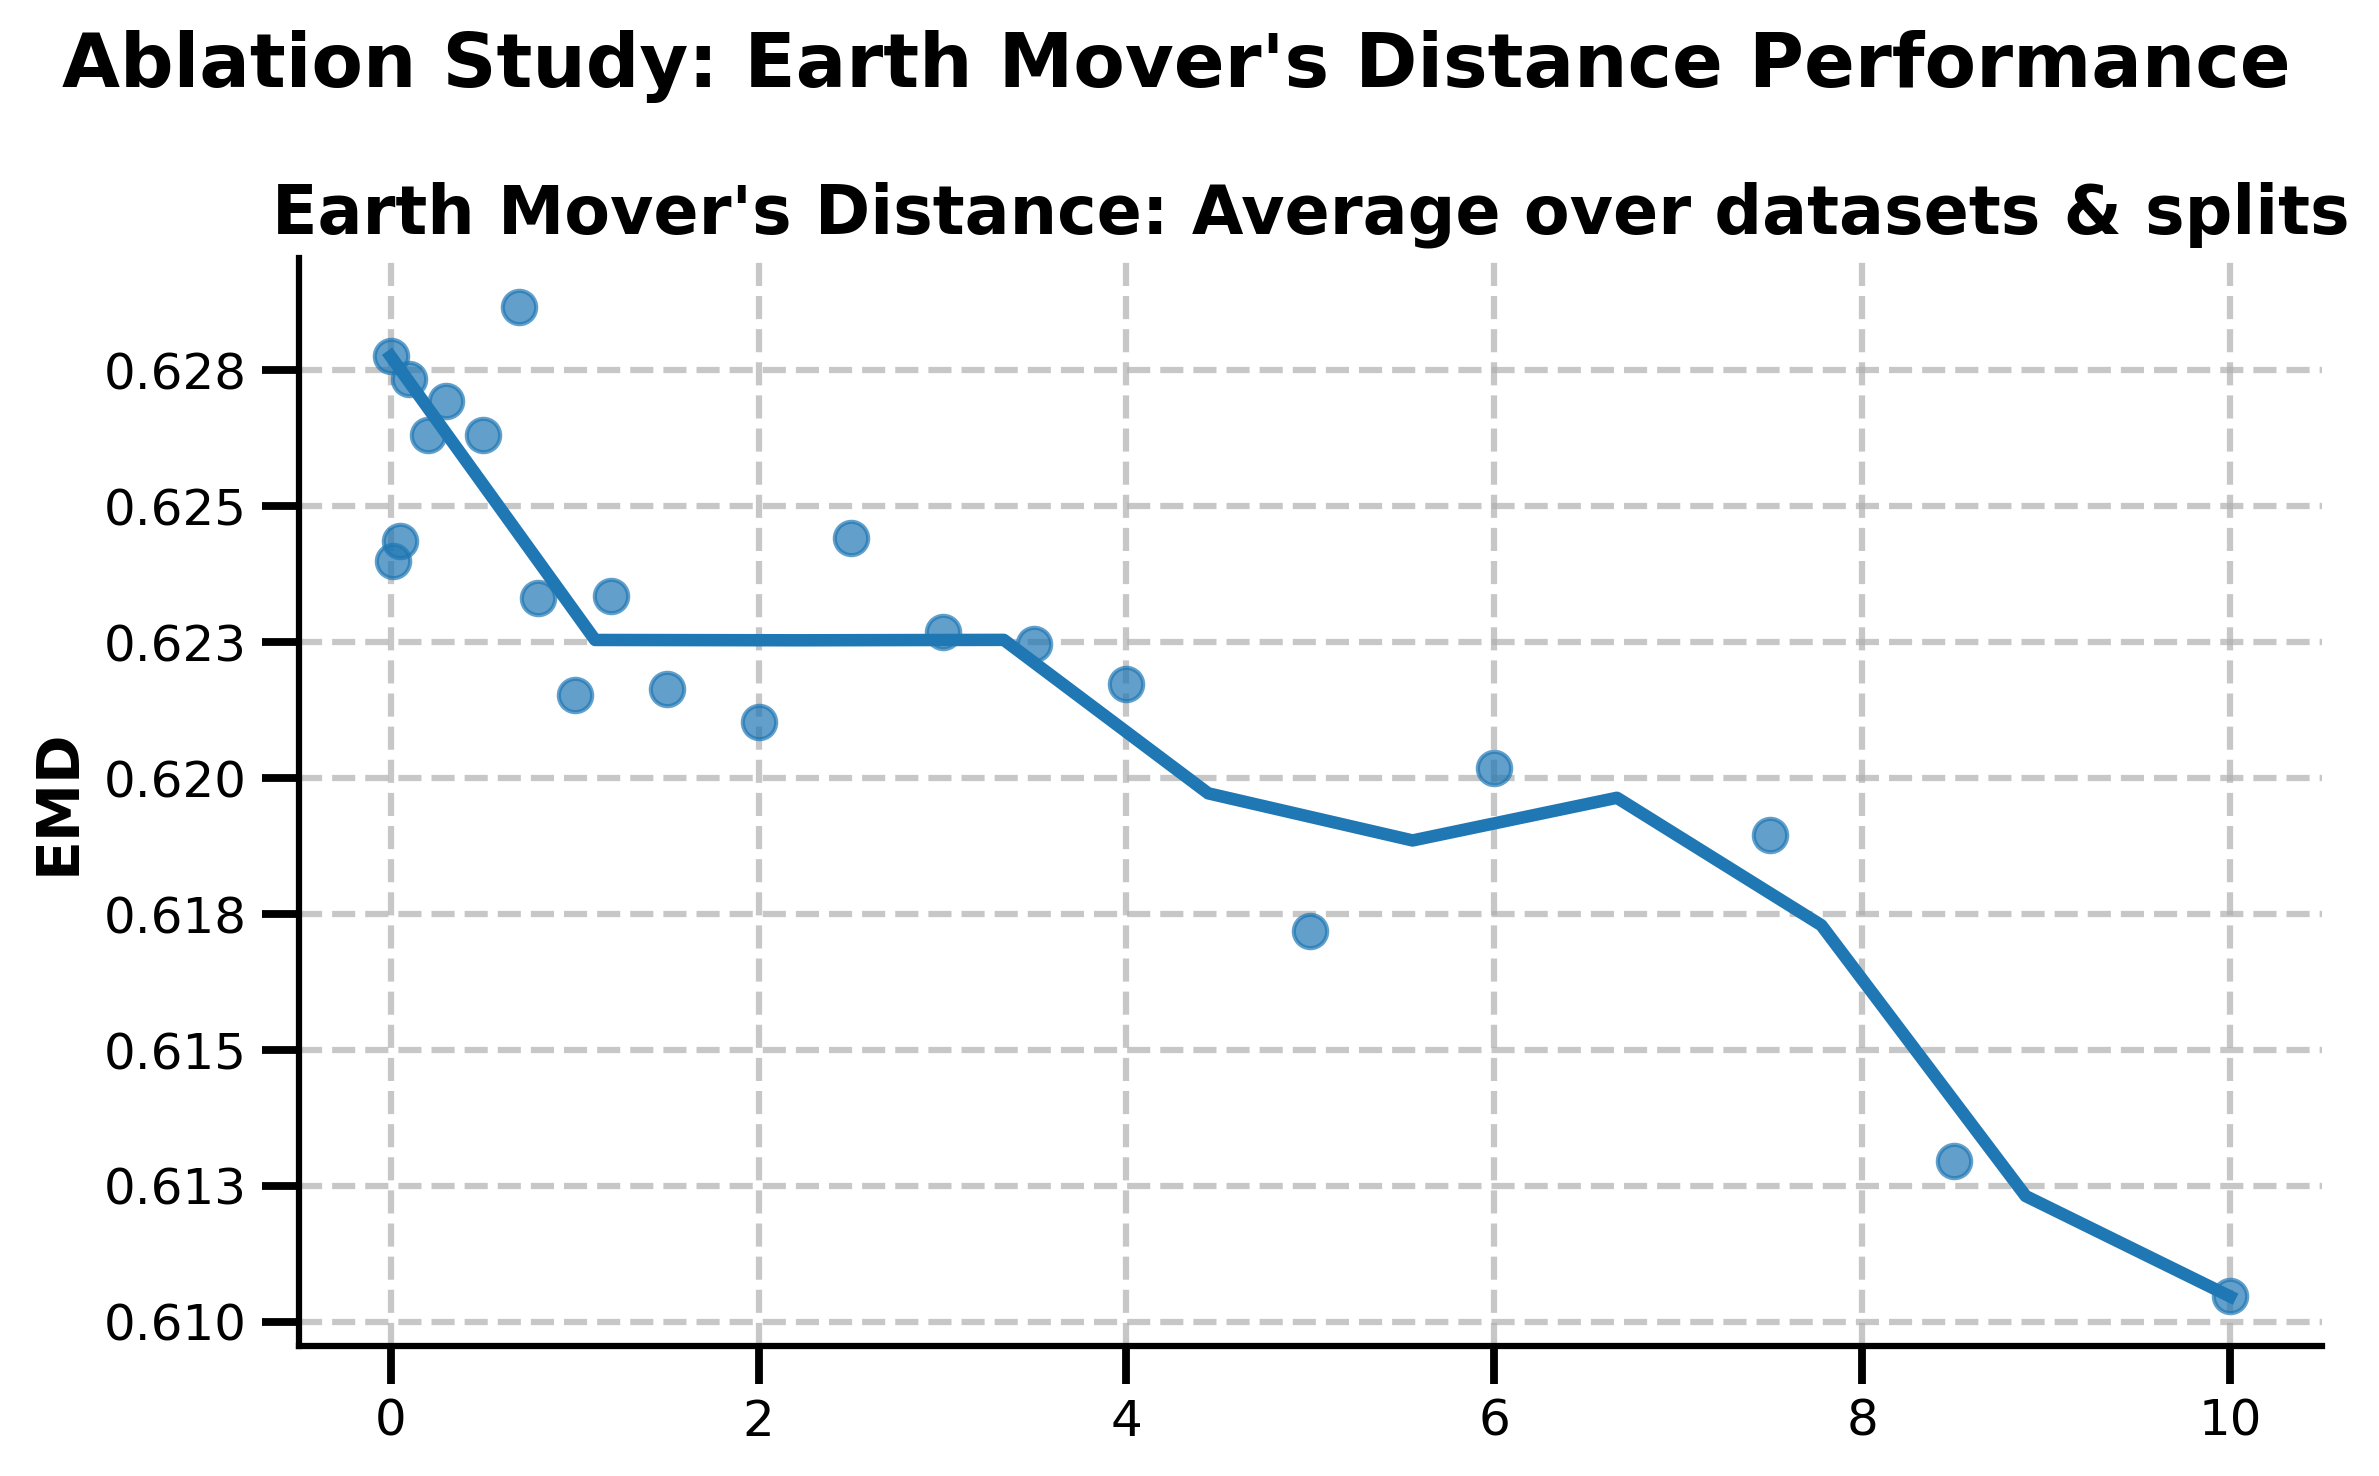

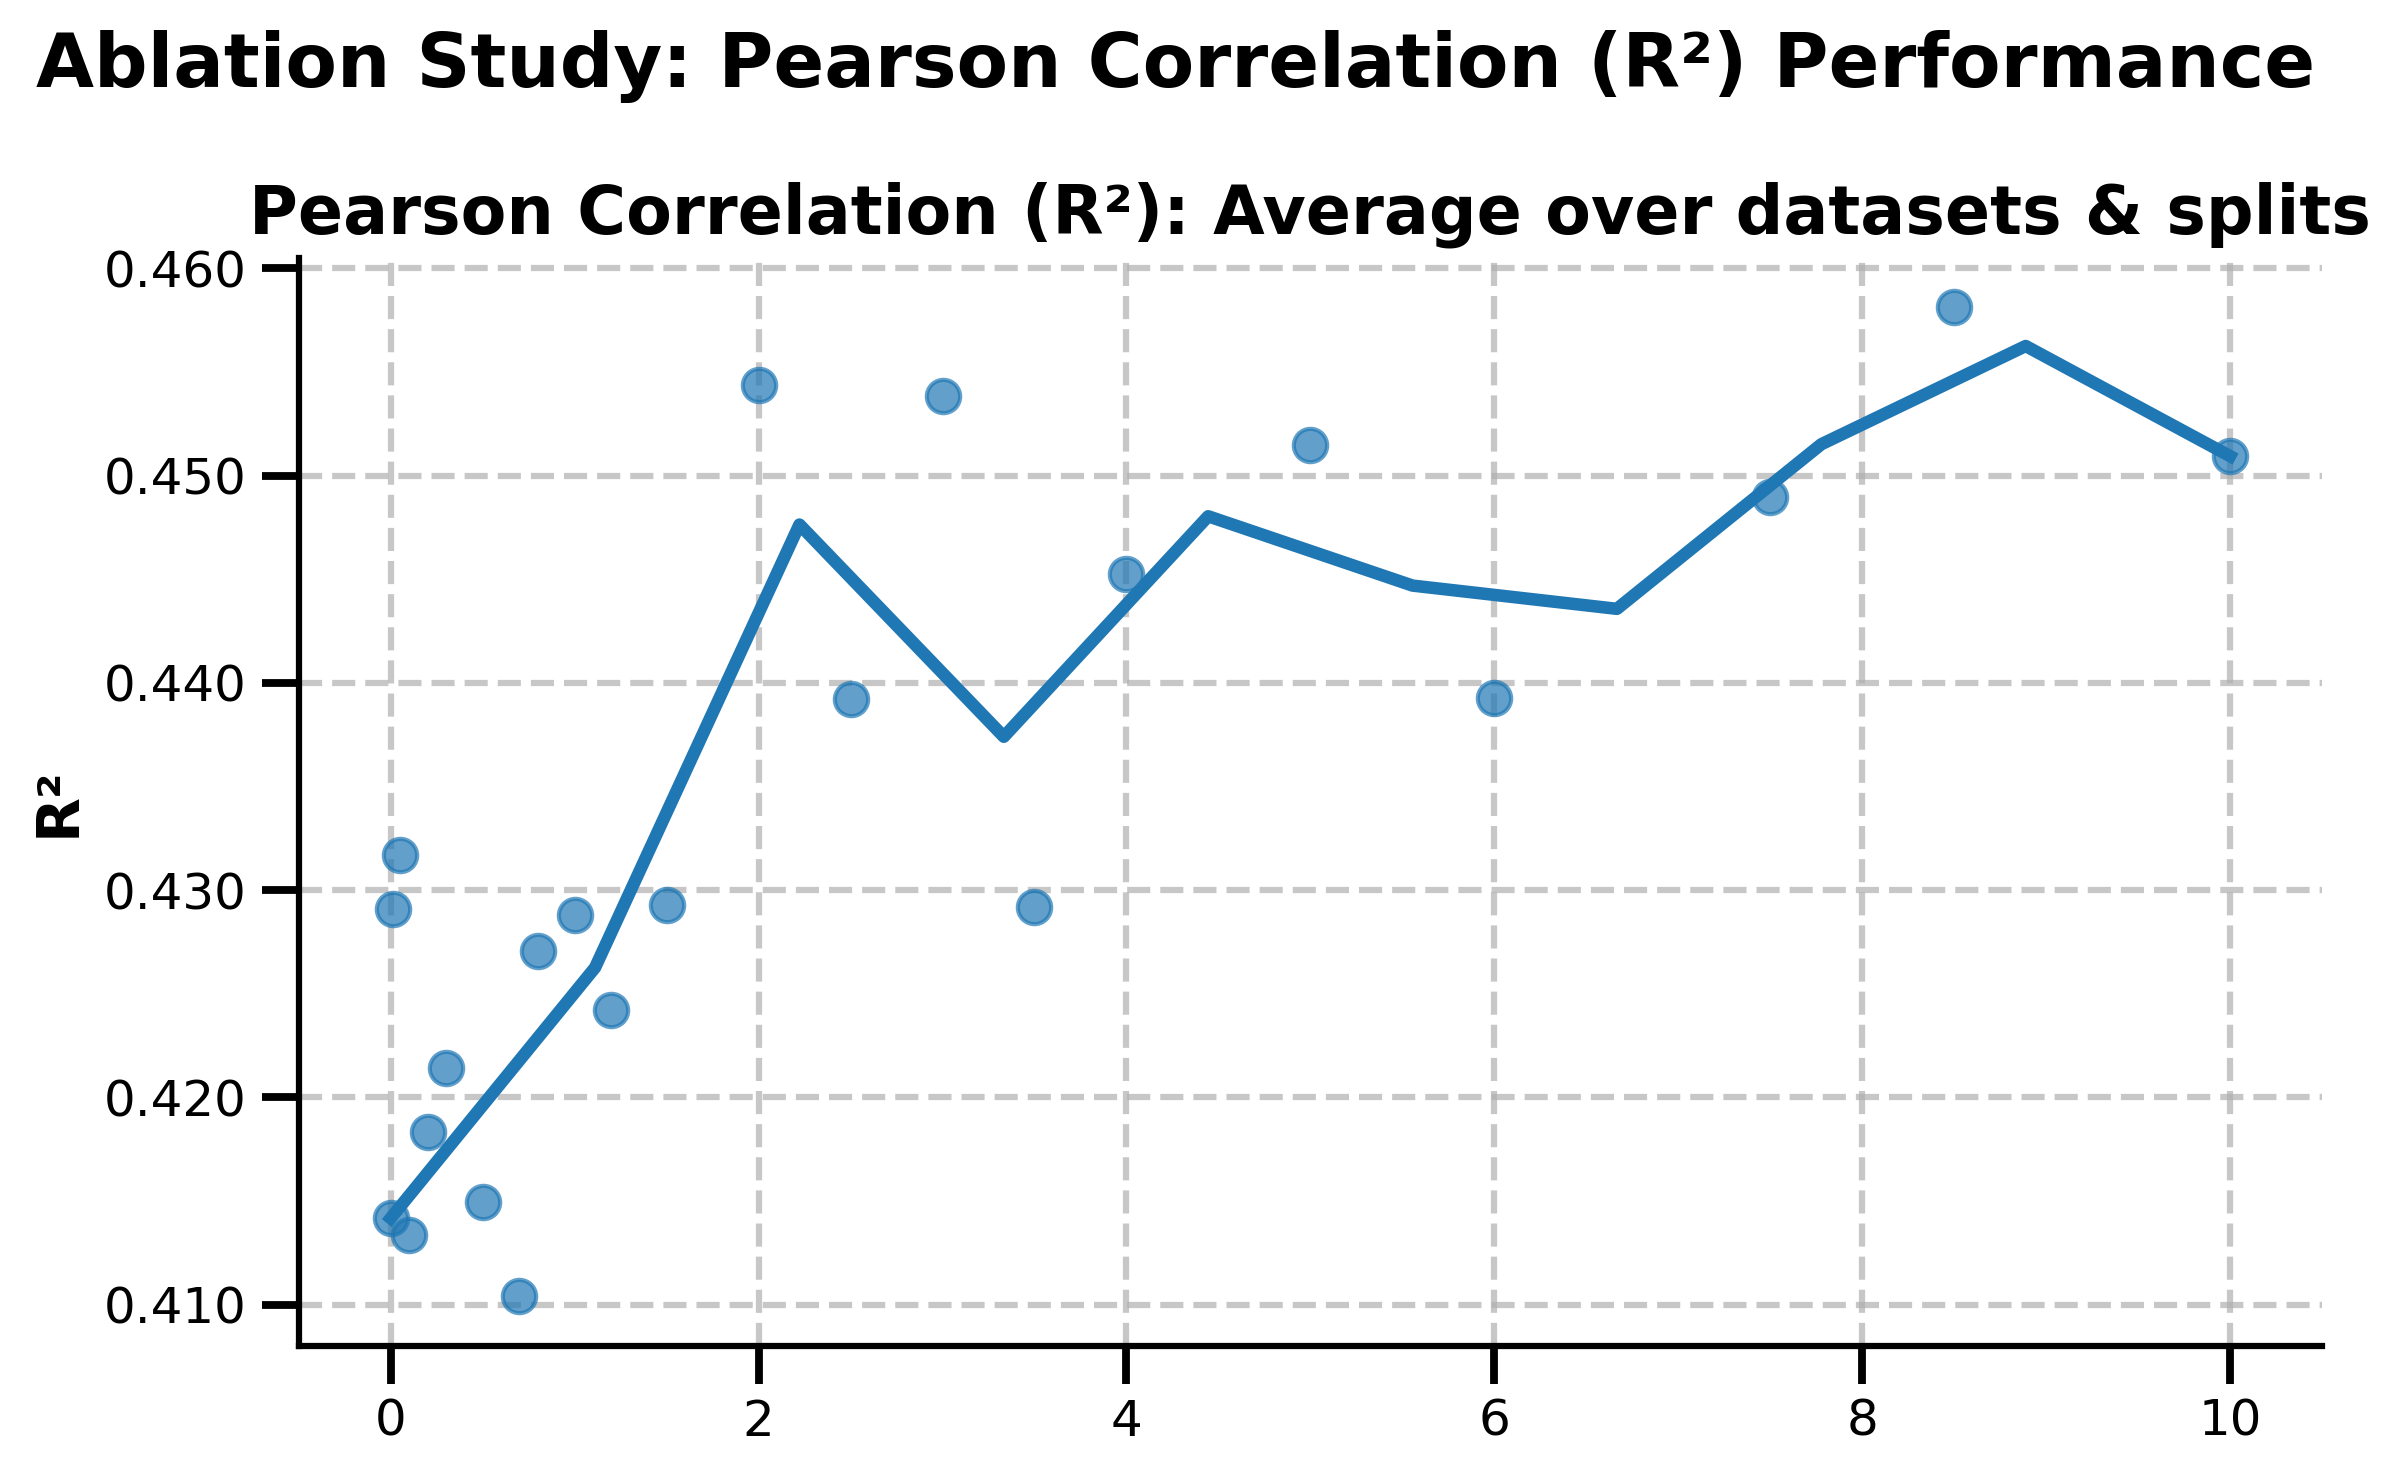

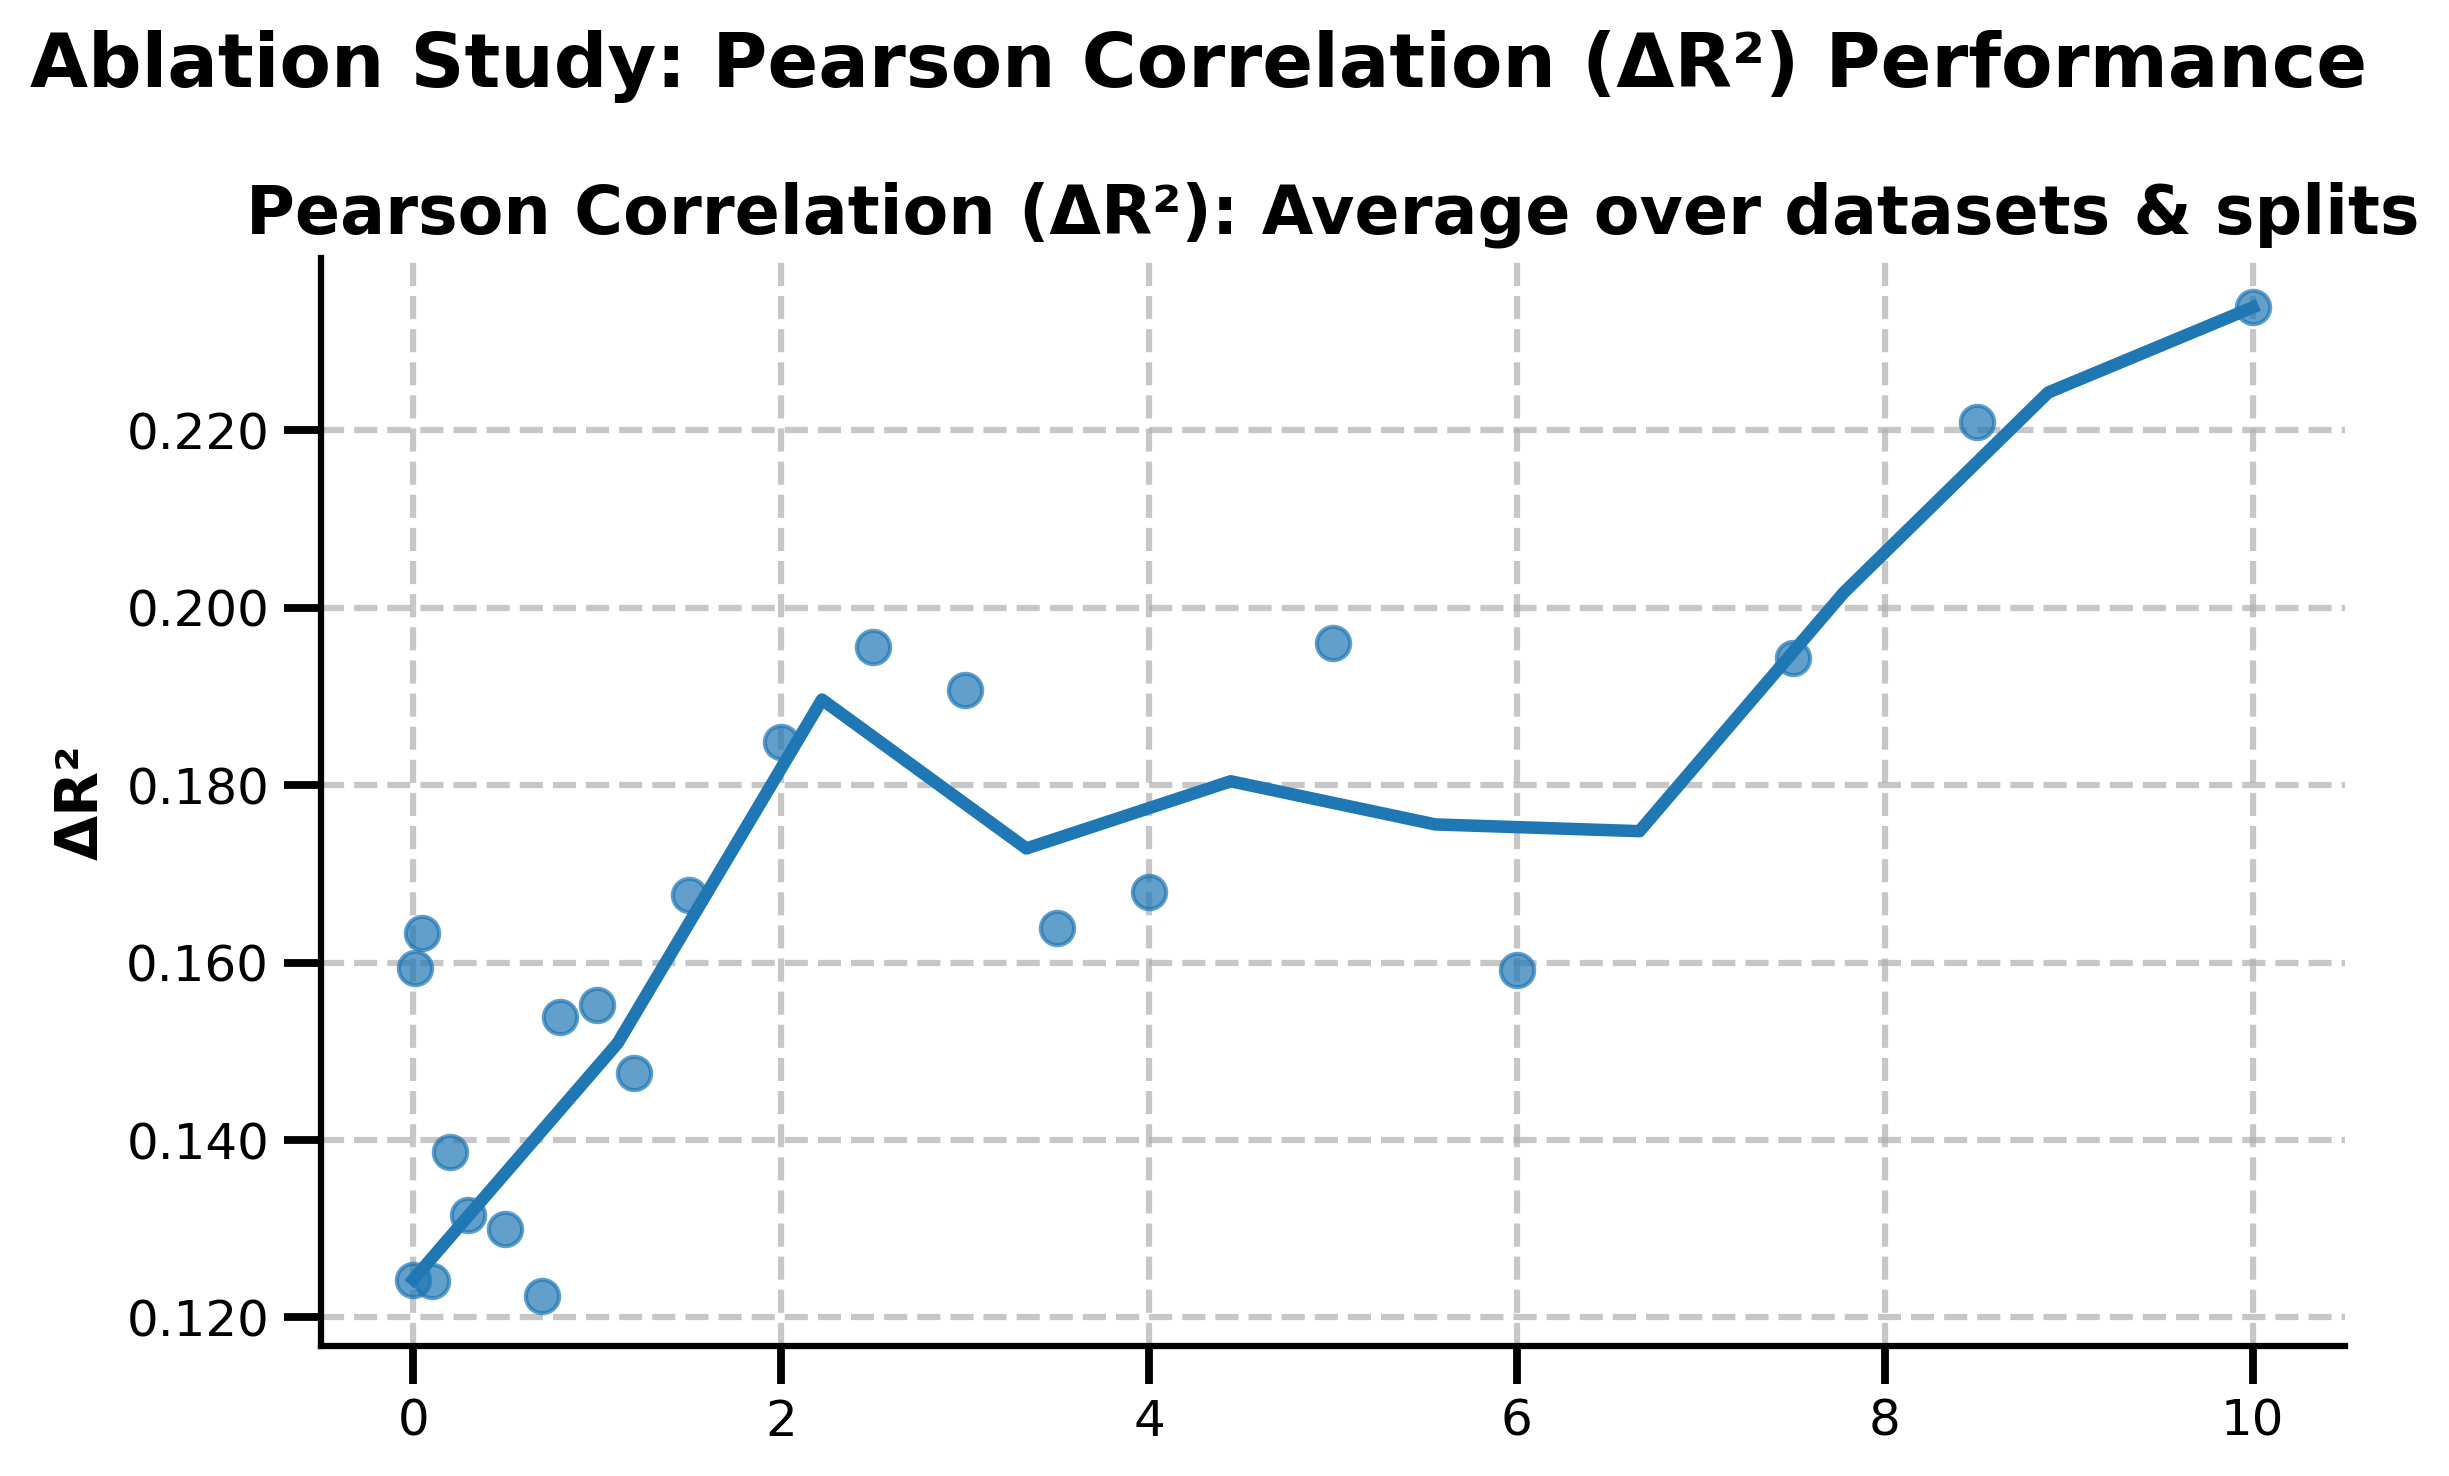

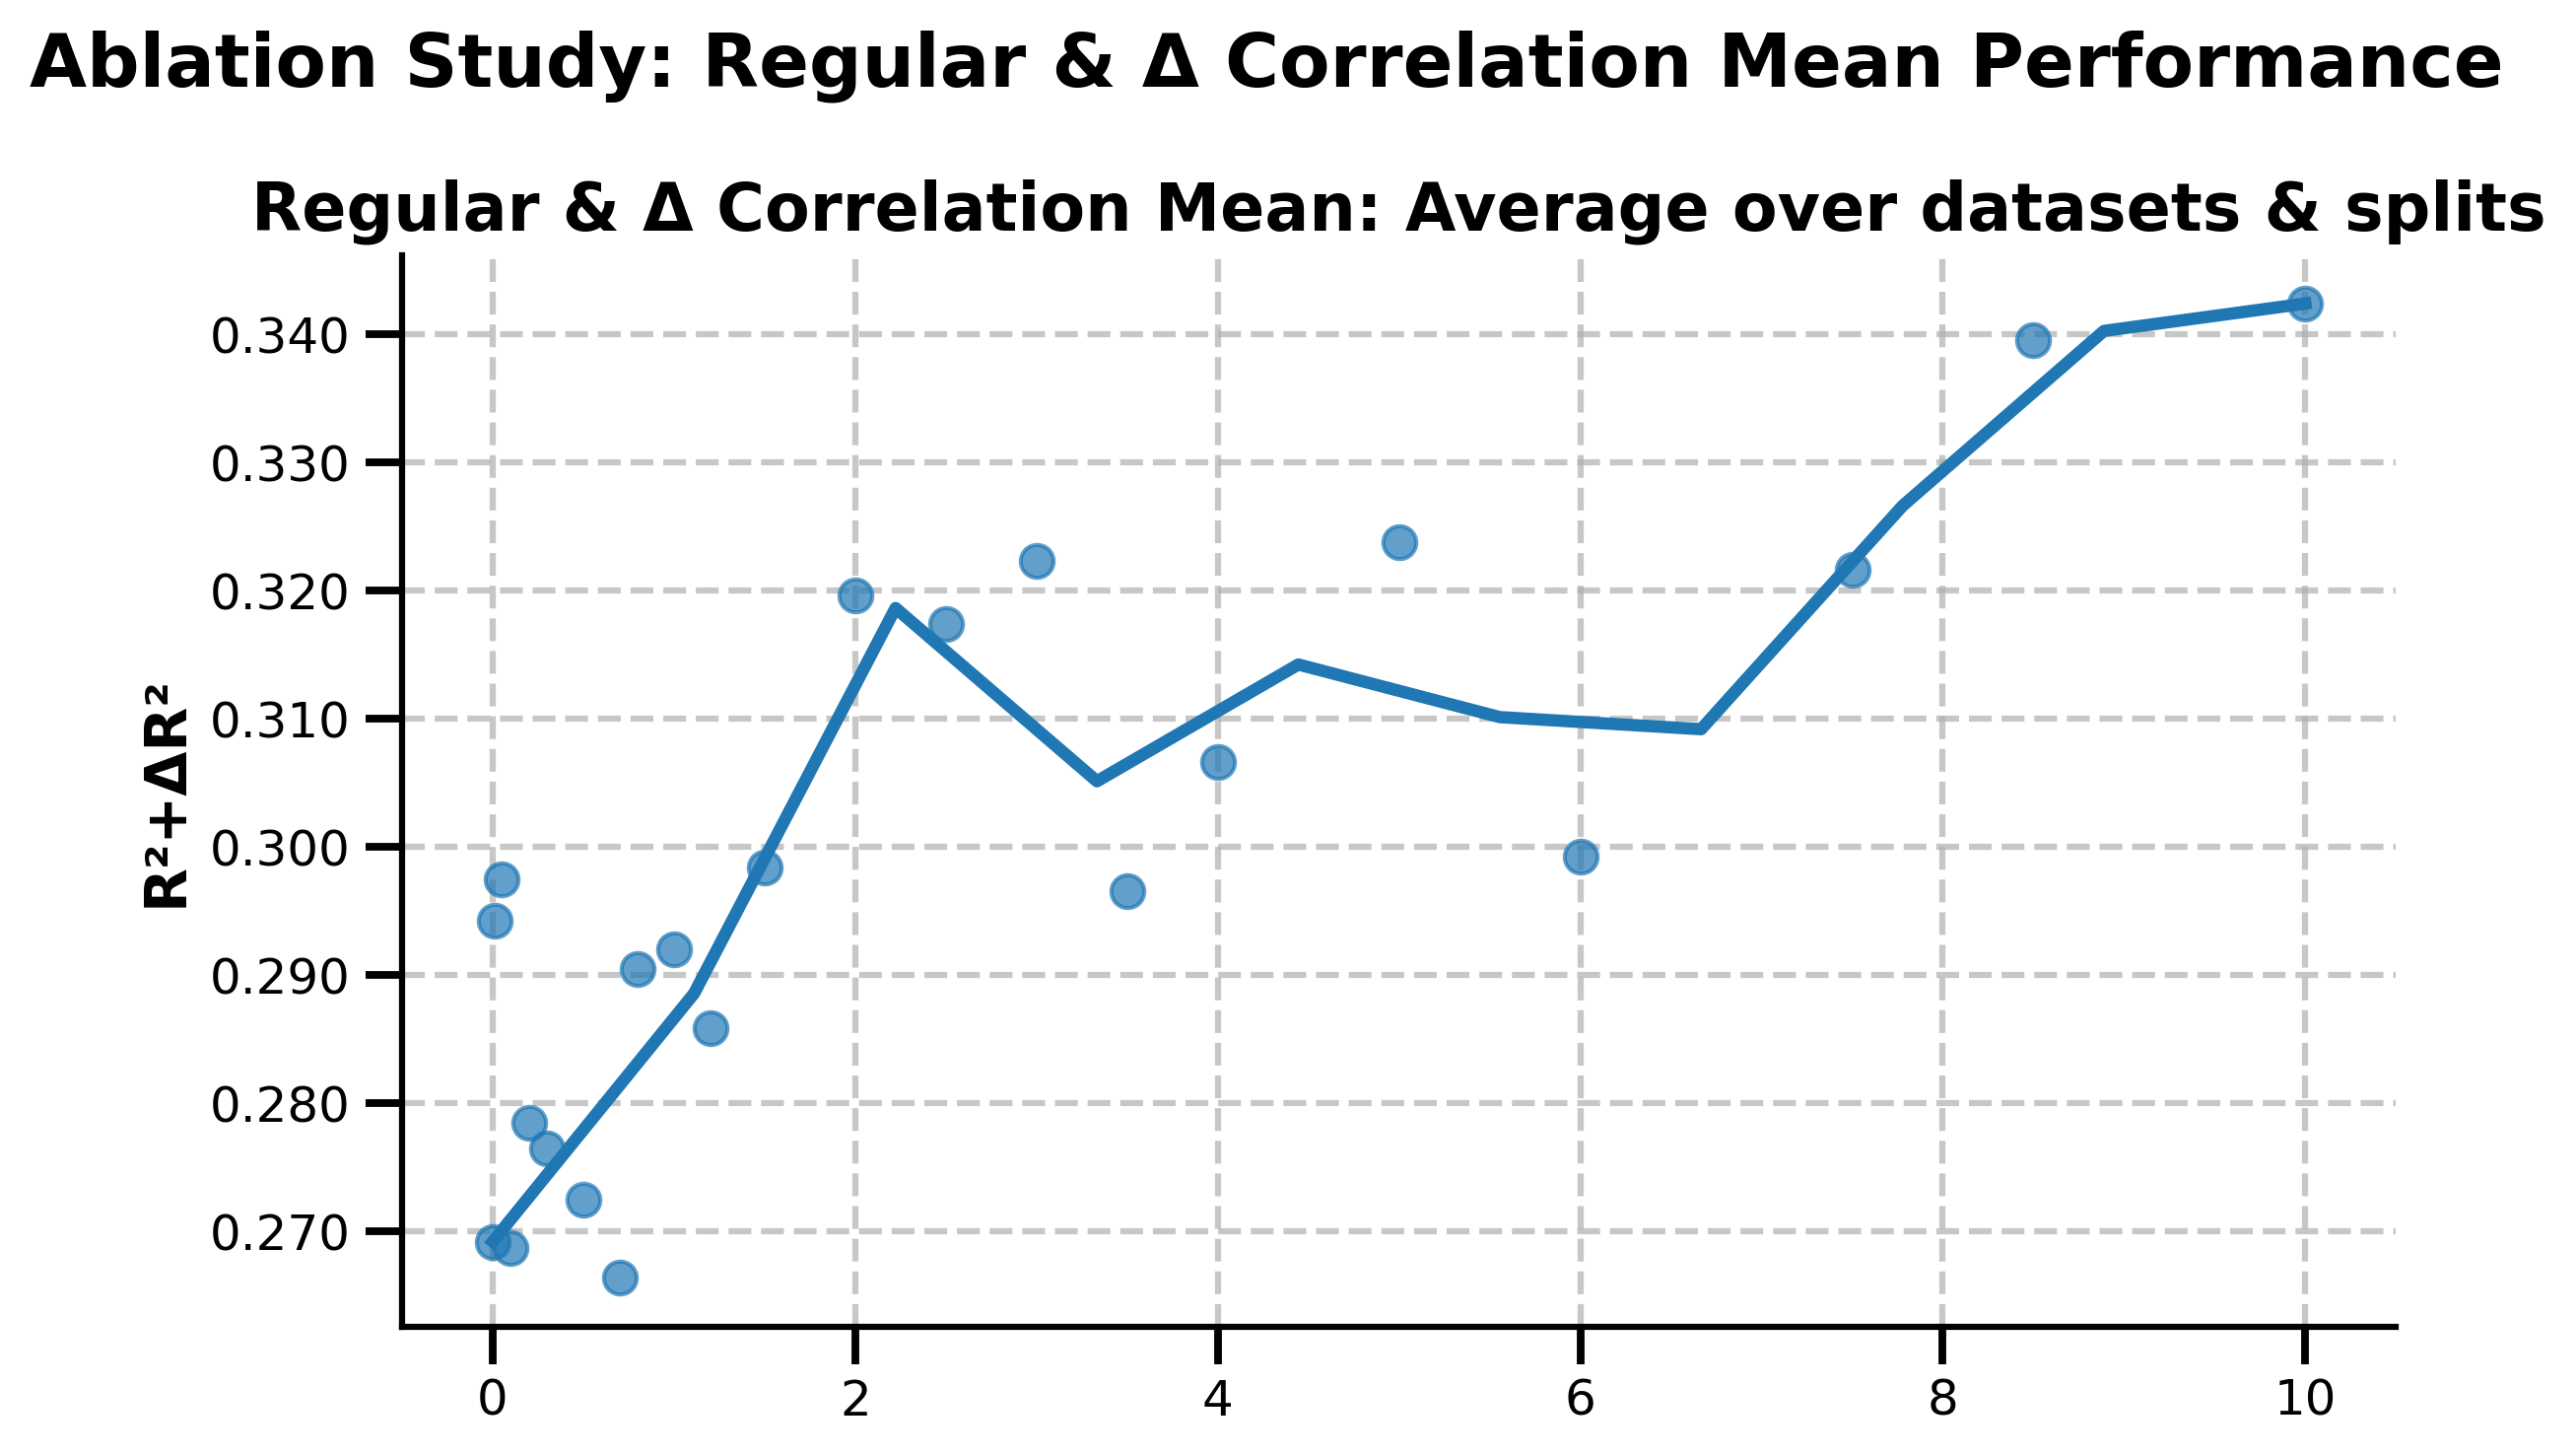

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Average over datasets & splits',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Function to create smooth curve
def smooth_curve(x, y, smoothness=10):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=1)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Define metrics
metrics = {
    'EMD': emd_results_mean,
    'R²': r2_results_mean,
    'ΔR²': r2_results_subtract_mean,
    'R²+ΔR²': correlation_mean,
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)',
    'R²+ΔR²': 'Regular & Δ Correlation Mean',
}

# Create individual figures for each metric
for metric_name, df in metrics.items():
    # Create a new figure for this metric
    fig, axes = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
    
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes.plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes.plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=8, alpha=0.7)
    
    axes.set_title(f'{metric_labels[metric_name]}: Average over datasets & splits', fontweight='bold', fontsize=16)
    axes.set_ylabel(metric_name, fontweight='bold')
    axes.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes.grid(True, linestyle='--', alpha=0.7)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    
#     # Plot All Genes on bottom row
#     all_data = plot_data[plot_data['Group'] == 'All Genes']
#     x = all_data['Hyperparameter'].values
#     y = all_data[metric_name].values
    
#     # Sort data by hyperparameter value
#     sort_idx = np.argsort(x)
#     x_sorted = x[sort_idx]
#     y_sorted = y[sort_idx]
    
#     # Create smoothed curve
#     x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
#     # Plot both the original points and the smoothed line
#     axes[1].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
#     axes[1].plot(x, y, 'o', color=colors['All Genes'], markersize=8, alpha=0.7)
    
#     axes[1].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=16)
#     axes[1].set_xlabel('Hyperparameter Value', fontweight='bold')
#     axes[1].set_ylabel(metric_name, fontweight='bold')
#     axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#     axes[1].grid(True, linestyle='--', alpha=0.7)
#     axes[1].spines['top'].set_visible(False)
#     axes[1].spines['right'].set_visible(False)
    
    # Add a suptitle
    plt.suptitle(f'Ablation Study: {metric_labels[metric_name]} Performance', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'final_figs/ablation_study_{metric_name}_separate.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'final_figs/ablation_study_{metric_name}_separate.svg', bbox_inches='tight', dpi=300)

plt.show()

In [34]:
!ls

ablation_emd.pdf
ablation_emd.png
ablation_r2.pdf
ablation_r2.png
ablation_r2_subtracted.pdf
ablation_r2_subtracted.png
ablation_study_EMD_separate.png
ablation_study_EMD_separate.svg
ablation_study_facet.pdf
ablation_study_facet.png
ablation_study_metrics_combined.png
ablation_study_metrics_separate.png
ablation_study_metrics_separate_smoothed.png
ablation_study_R²_separate.png
ablation_study_R²_separate.svg
ablation_study_R²+ΔR²_separate.png
ablation_study_R²+ΔR²_separate.svg
ablation_study_results_detailed.pdf
ablation_study_results_detailed.png
ablation_study_results_improved.pdf
ablation_study_results_improved.png
ablation_study_results.pdf
ablation_study_results.png
ablation_study_ΔR²_separate.png
ablation_study_ΔR²_separate.svg
all_bms_eraslan_ct.pkl
combined_ablation.pdf
competitors
disentanglement_benchmark_kang.ipynb
emd_ablation.pdf
emd_ablation.png
Feb9_neurips_debug_dis2pmPoisson2.ipynb
figure_notebooks
final_figs
ioannis
Jan16_saveBest_kang2018.ipynb
Mar8_counterfactual_p